# Проект SF TripAdvisor Rating - прогнозирование рейтинга ресторана на TripAdvisor.
**Автор - Михаил Пустовалов**
Версия 1, от 15 ноября 2020

Чтобы пропустить EDA и сразу запустить подготовку данных и модель - переходите к 6 секции.

# 0. Импорты.

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import re
import collections
from pprint import *
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import os
import seaborn as sns
%matplotlib inline
#Make sure that input files are in place
for dirname, _, filenames in os.walk('./inputs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./inputs/global-city-population-estimates.xls
./inputs/kaggle_task.csv
./inputs/main_task.csv
./inputs/.ipynb_checkpoints/main_task-checkpoint.csv


Прочие настройки

In [2]:
#настройки графиков
sns.set(rc={'figure.figsize':(20,7)}, style = 'whitegrid', palette = 'tab10')
#зафиксируем random seed
RANDOM_SEED = 42
#pip freeze
!pip freeze > ./outputs/requirements.txt

# 1. Загрузка и осмотр данных.

Загрузим данные и посмотрим на них.

In [3]:
DATA_DIR = './inputs'
OUTPUT_DIR = './outputs'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


В трейне у нас 40000 записей, и в них есть пропуски.

In [5]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


В тесте 10000 записей, тоже есть пропуски.

In [7]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


Объединяем тест и трейн.

In [8]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* Restraunt_id: непонятный зверь. Неуникальный, но id.
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [10]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
19039,id_165,Dublin,"['Irish', 'Cafe']",166.0,$,177.0,"[['Great down to earth food!', 'Wonderful litt...",/Restaurant_Review-g186605-d5821541-Reviews-Ge...,d5821541,1,4.5
5837,id_5837,Berlin,NaN,3707.0,NaN,7.0,"[['Very tasty food - also for delivery'], ['05...",/Restaurant_Review-g187323-d5522995-Reviews-Ti...,d5522995,0,0.0
32690,id_801,Milan,"['Asian', 'Korean', 'Vegetarian Friendly', 'Ve...",803.0,$$ - $$$,364.0,"[['Nice ambiance with good food', 'Great place...",/Restaurant_Review-g187849-d1024682-Reviews-HA...,d1024682,1,4.0
4862,id_4862,Berlin,NaN,3237.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d10632919-Reviews-R...,d10632919,0,0.0
15426,id_3264,Barcelona,NaN,3265.0,NaN,18.0,"[['Best sushi and service', 'Very good at a gr...",/Restaurant_Review-g187497-d8462228-Reviews-D_...,d8462228,1,4.5


Признаки будем очищать и причёсывать.

## 2. Очистка и подготовка данных.
Пойдём немного по другому маршруту, нежели предложен в базовом решении. Каждый признак мы посмотрим сначала отдельно, заполним NaN, удалим дубликаты, погенеруем очевидные новые признаки.

Первым делом переименуем столбцы, чтобы было удобнее писать. И вообще, пробелы всякие в названиях в итоге могут привести к внезапным ошибкам.

In [11]:
data.rename(columns = {'Restaurant_id':'rest_id', 
                     'City':'city', 
                     'Cuisine Style':'cus_style',
                     'Ranking':'ranking', 
                     'Rating':'rating', 
                     'Price Range': 'pricing',
                     'Reviews':'reviews',
                     'Number of Reviews':'review_num'},
                      inplace = True)
data.columns

Index(['rest_id', 'city', 'cus_style', 'ranking', 'pricing', 'review_num',
       'reviews', 'URL_TA', 'ID_TA', 'sample', 'rating'],
      dtype='object')

Посмотрим на страницу ресторана на Tripadvisor. Нас очень интересует панель с ранкингом, ценой, кухнями и т.д. Потом, возможно, будем парсить.

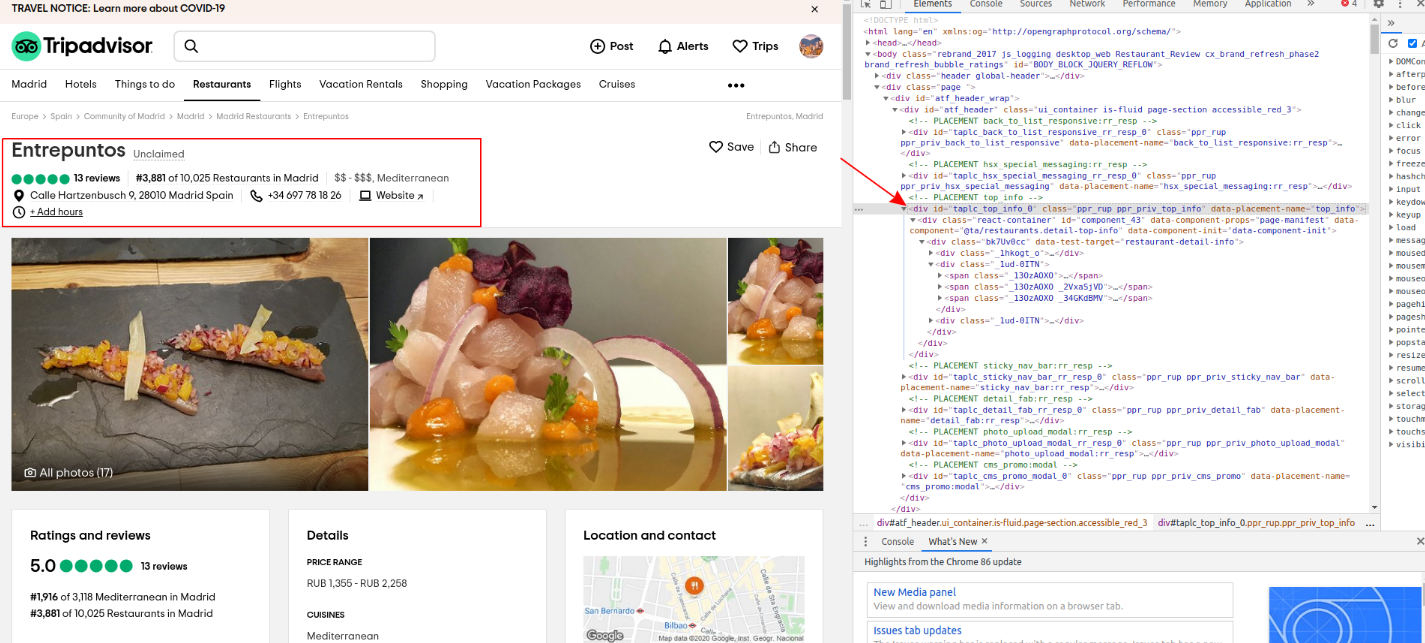

## 2.1. Restaurant_id и ID_TA
Логично предположить, что столбец с названием Restaurant_id - это некоторые идентификаторы ресторанов, которые должны быть уникальными.
Посмотрим пропуски и уникальные значения.

In [12]:
print('Количество пропусков: ', data['rest_id'].isnull().sum())
print('Количество уникальных значений: ', data['rest_id'].nunique())

Количество пропусков:  0
Количество уникальных значений:  13094


Пропусков нет. А вот уникальных значений явно меньше, чем записей. Вывод - не такие они и уникальные. Посмотрим поближе.

In [13]:
print('Повторения значений:\n', data['rest_id'].value_counts())

Повторения значений:
 id_633      19
id_436      19
id_871      19
id_227      19
id_344      18
            ..
id_15905     1
id_10959     1
id_12155     1
id_15009     1
id_9821      1
Name: rest_id, Length: 13094, dtype: int64


Возьмём самый часто встречающийся id.

In [14]:
data.query('rest_id == "id_436"')

,rest_id,city,cus_style,ranking,pricing,review_num,reviews,URL_TA,ID_TA,sample,rating
436,id_436,Lisbon,"['European', 'Portuguese']",2904.0,NaN,2.0,"[[], []]",/Restaurant_Review-g189158-d5003144-Reviews-Gu...,d5003144,0,0.0
12955,id_436,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Glute...",437.0,$$ - $$$,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",/Restaurant_Review-g187497-d1592613-Reviews-La...,d1592613,1,4.5
14674,id_436,Copenhagen,"['European', 'Spanish', 'Mediterranean', 'Vege...",437.0,$$ - $$$,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",/Restaurant_Review-g189541-d8738362-Reviews-To...,d8738362,1,4.0
16118,id_436,Oporto,"['European', 'Portuguese', 'Soups', 'Cafe', 'V...",437.0,$,71.0,"[['Super nice healthy and good', 'Great lunch ...",/Restaurant_Review-g189180-d9463122-Reviews-Ca...,d9463122,1,4.5
16215,id_436,Budapest,"['American', 'Vegetarian Friendly', 'Vegan Opt...",437.0,$,68.0,"[['Excellent', 'Best burger ever!'], ['12/05/2...",/Restaurant_Review-g274887-d10438365-Reviews-B...,d10438365,1,4.5
17377,id_436,Luxembourg,['Asian'],437.0,NaN,2.0,"[['ZEN'], ['06/11/2016']]",/Restaurant_Review-g190356-d743888-Reviews-Zen...,d743888,1,4.5
18168,id_436,Oslo,"['European', 'Scandinavian']",437.0,$$$$,51.0,"[['Stunning views over Oslo', 'Brilliant break...",/Restaurant_Review-g190479-d2036436-Reviews-Re...,d2036436,1,4.0
18497,id_436,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",437.0,$$ - $$$,855.0,"[['Nice Napoli style pizza place', 'Great Neap...",/Restaurant_Review-g187849-d1553645-Reviews-Il...,d1553645,1,4.0
22554,id_436,Ljubljana,NaN,437.0,NaN,14.0,"[['Terrible staff and service', 'Disrespectful...",/Restaurant_Review-g274873-d12607480-Reviews-C...,d12607480,1,3.0
23313,id_436,Krakow,['Vegetarian Friendly'],437.0,$$ - $$$,18.0,"[['Great find, 100% recommend', 'Amazing brunc...",/Restaurant_Review-g274772-d12404722-Reviews-R...,d12404722,1,4.5


Совсем разные рестораны.

**Вывыод:** rest_id не подходит в качестве уникального идентификатора. Пока просто почистим его от "id_" и переведём в числовой формат. На этапе корреляций будет выяснено, что это такое. (Опять пост-знание).

In [15]:
data['rest_id'] = data['rest_id'].apply(lambda x: int(str(x).split('_')[1]))

Посмотрим ID_TA. Там тоже не все значения уникальны, но неуникальных совсем немного.

In [16]:
print(f'Отстутствующих данных в столбце ID_TA: {data.ID_TA.isnull().sum()}')
print(f'Уникальных записей в столбце ID_TA: {data.ID_TA.nunique()}\n'
      f'Неуникальных записей в столбце ID_TA: {data.ID_TA.count() - data.ID_TA.nunique()}')

Отстутствующих данных в столбце ID_TA: 0
Уникальных записей в столбце ID_TA: 49963
Неуникальных записей в столбце ID_TA: 37


In [17]:
id_dupl = data[data.ID_TA.isin(data.ID_TA.mode().values)]
pd.set_option('display.max_rows', None)
id_dupl.sort_values('ID_TA')

,rest_id,city,cus_style,ranking,pricing,review_num,reviews,URL_TA,ID_TA,sample,rating
48946,3242,Madrid,NaN,3244.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0
23980,3239,Madrid,NaN,3241.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0
28388,1229,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1231.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,1,4.0
4534,4534,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1253.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,0,0.0
118,118,Warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,0,0.0
36920,1800,Warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,1,3.5
23576,1277,Madrid,"['Asian', 'Thai', 'Vegetarian Friendly']",1279.0,$$ - $$$,70.0,"[['Delicious soup', 'My weekly treat'], ['03/1...",/Restaurant_Review-g187514-d10440367-Reviews-B...,d10440367,1,4.0
8551,8551,Madrid,"['Asian', 'Thai', 'Vegetarian Friendly']",1206.0,$$ - $$$,70.0,"[['Delicious soup', 'My weekly treat'], ['03/1...",/Restaurant_Review-g187514-d10440367-Reviews-B...,d10440367,0,0.0
21583,3810,Madrid,"['American', 'German', 'European', 'Central Eu...",3812.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463,1,4.0
14732,3804,Madrid,"['American', 'German', 'European', 'Central Eu...",3806.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463,1,4.0


In [18]:
id_dupl.groupby('ID_TA').nunique()

,rest_id,city,cus_style,ranking,pricing,review_num,reviews,URL_TA,sample,rating
ID_TA,,,,,,,,,,
d10047799,2,1,0,2,0,1,1,1,1,1
d1028622,2,1,1,2,1,1,1,1,2,2
d10316215,2,1,1,1,1,1,1,1,2,2
d10440367,2,1,1,2,1,1,1,1,2,2
d11674463,2,1,1,2,0,1,1,1,1,1
d11698990,2,1,0,2,0,1,1,1,1,1
d11921719,2,1,0,2,0,1,1,1,1,1
d11999956,2,1,1,2,1,1,1,1,1,1
d1235635,2,1,0,2,0,1,1,1,2,2


In [19]:
# небольшой технический момент
id_dupl = id_dupl.set_index('ID_TA').sort_index()
pd.set_option('display.max_rows', 10)

Чистой воды задвоение, то есть все рестораны попали по 2 раза. При этом некоторые поля одинаковые, а некоторые - разные. Cсылка у каждого ресторана жёстко привязана к ID_TA. 

In [20]:
print(f'Задвоенных ID в сете: {len(id_dupl)}')
print(f'Уникальных ссылок: {id_dupl.URL_TA.nunique()}')
print(f'Уникальных ранкингов: {id_dupl.ranking.nunique()}')

Задвоенных ID в сете: 74
Уникальных ссылок: 37
Уникальных ранкингов: 72


В принципе, задвоенных данных не так много, и можно их просто выбросить. С другой стороны, парсить Trip Advisor интереснее. Сначала отметим, что целевая переменная рейтинг иногда различается в задвоенной записи, причём второе значение всегда 0. Поэтому сначала присвоим нулевым рейтингам в дублях новые значения, а потом выкинем дубли из большого датасета, всё равно какие (первый или второй), потому что данные на них мы обновим. Такая же штука с задвоениями в review_num, о всего у двух ресторанов и там очень маленькое различие, поэтому это мы проигнорируем.

Остальные данные с TA мы не парсим, т.к. со времени составления датасета они могли обновиться и получится что у нас будут данные из условного будущего.

In [21]:
for id_ta in id_dupl.index:
    data.loc[data['ID_TA'] == id_ta, 'rating'] = data.query('ID_TA == @id_ta')['rating'].max()

In [22]:
#Поехали парсить
rank_pattern = re.compile('#[\d,.]+')
price_pattern = re.compile('(\$ |\$\$ - \$\$\$|\$\$\$\$)')
id_dupl.drop_duplicates(subset = ['URL_TA'], inplace = True)
for url in id_dupl.URL_TA:
    r = requests.get('https://www.tripadvisor.com' + url)
    soup = BeautifulSoup(r.text, 'html.parser')
    tag = soup.find('div', class_ ='ppr_rup ppr_priv_top_info')
    if tag is not None:
        rank = rank_pattern.search(tag.text)
        price = price_pattern.search(tag.text)
        if rank is not None:
            id_dupl.loc[id_dupl['URL_TA'] == url,'ranking'] = int(re.sub('[#,]', '', rank[0]))
        if price is not None:
            id_dupl.loc[id_dupl['URL_TA'] == url,'pricing'] = price[0]
    else:
        print(f'Нет страницы ресторана по ссылке {url}')

Нет страницы ресторана по ссылке /Restaurant_Review-g187514-d11698990-Reviews-Verdello_Restaurante-Madrid.html
Нет страницы ресторана по ссылке /Restaurant_Review-g187514-d5617412-Reviews-Green_Marta_Iii-Madrid.html


На нет и суда нет. Забьём.

In [23]:
data = data.drop_duplicates(subset = ['URL_TA']).set_index('ID_TA')
#Заодно поставим индекс на ID_TA, он теперь уникальный
#Обновим фрейм
data.update(id_dupl)

## 2.2. Сity.

Город, в котором располагается ресторан. Посмотрим пропуски и уникальные значения.

In [24]:
print('Количество пропусокв: ', data['city'].isnull().sum())
print(f'Число уникальных городов {data.city.nunique()}\n')

Количество пропусокв:  0
Число уникальных городов 31



<AxesSubplot:>

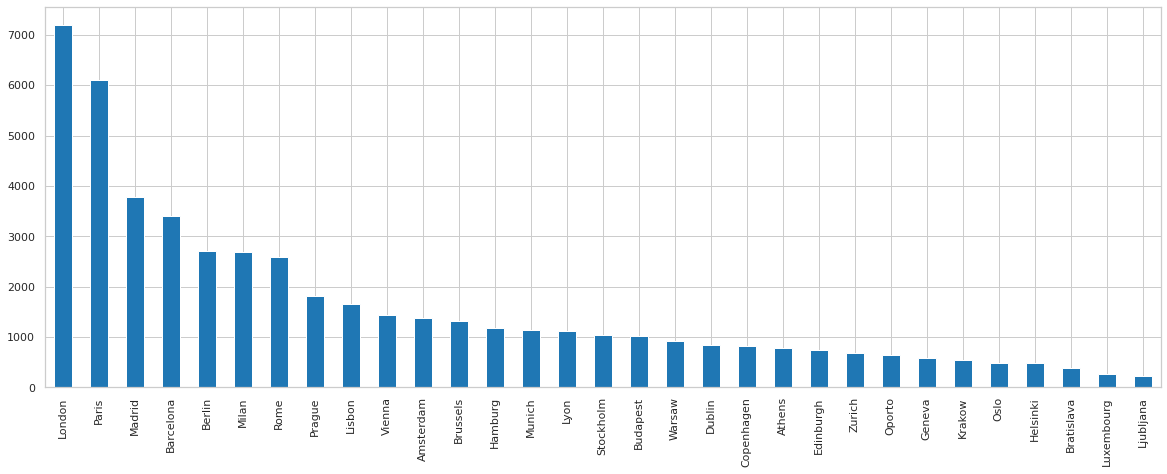

In [25]:
data.city.value_counts().plot(kind = 'bar')

Рестораны по городам распределены неравномерно. Возможно, зависит от населения города, или количества туристов. Растащим на dummy-переменные.

In [26]:
data = pd.merge(data, pd.get_dummies(data['city']), 
                left_index=True, right_index=True)

## 2.3. Cuisine Style
### 2.3.1. Осмотр данных.

Список кухонь, которые подаются в ресторане. Есть пропуски. Данные сложены в виде строк, внитри которых лежат списки. Преобразуем строки в списки при помощи функции eval.
Пропуски заполняем строкой "Unknown".

In [27]:
print(f'Число пропусков в стоблце "cus_style": {data.cus_style.isnull().sum()}\n')
print('Число пропусков в стоблце "cus_style":', 
      (round(data.cus_style.isnull().sum()
             /data.cus_style.count()*100,2)))

Число пропусков в стоблце "cus_style": 11584

Число пропусков в стоблце "cus_style": 30.18


Очень много пропусков. Парсить долго, поэтому заменим на Unknown. Преобразуем в списки eval'ом. Добавим dummy-переменную unknown cuisine.

In [28]:
data['cus_style'].fillna(value = '["Unknown"]', 
                         inplace = True)
data['cus_style'] = data['cus_style'].apply(lambda x: eval(x) if x!='nan' 
                                            else ["Unknown"])

In [29]:
data['unknown_cus'] = data['cus_style'].apply(lambda x: 1 if x == ["Unknown"] 
                                              else 0)

Посмотрим что там с разнообразием кухонь.

In [30]:
cus = data.explode(column = 'cus_style').reset_index()

In [31]:
cus.groupby('cus_style').count()['ID_TA'].sort_values(ascending = False)

cus_style
Vegetarian Friendly    14007
European               12553
Unknown                11584
Mediterranean           7810
Italian                 7430
                       ...  
Yunnan                     2
Salvadoran                 1
Latvian                    1
Xinjiang                   1
Burmese                    1
Name: ID_TA, Length: 126, dtype: int64

<AxesSubplot:xlabel='cus_style'>

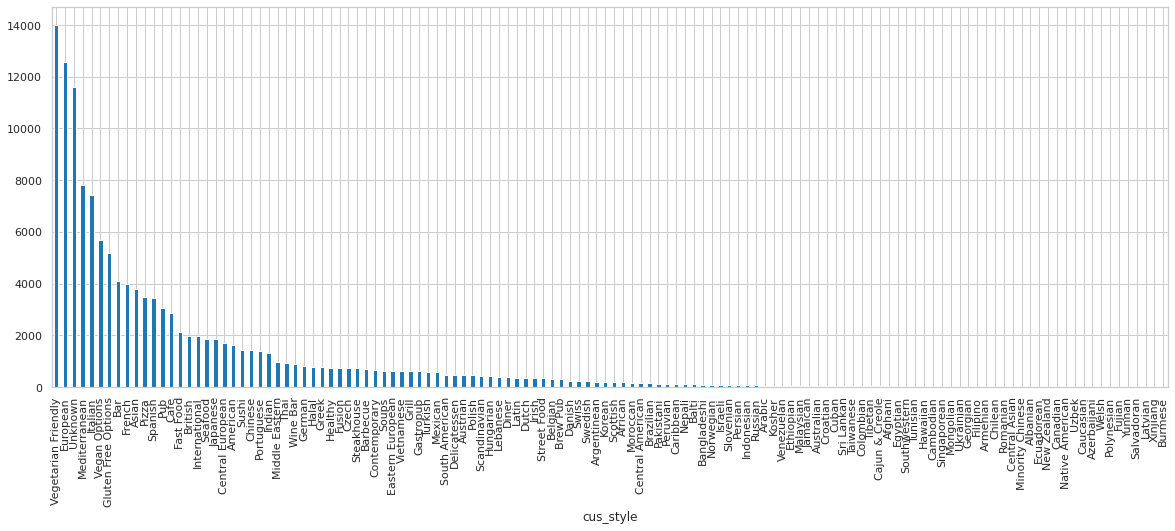

In [32]:
cus_stats = (cus.groupby('cus_style')['ID_TA'].count()
                                              .sort_values(ascending=False))
cus_stats.plot(kind = 'bar')

Unknown мешается. Уберём с графика.

<AxesSubplot:xlabel='cus_style'>

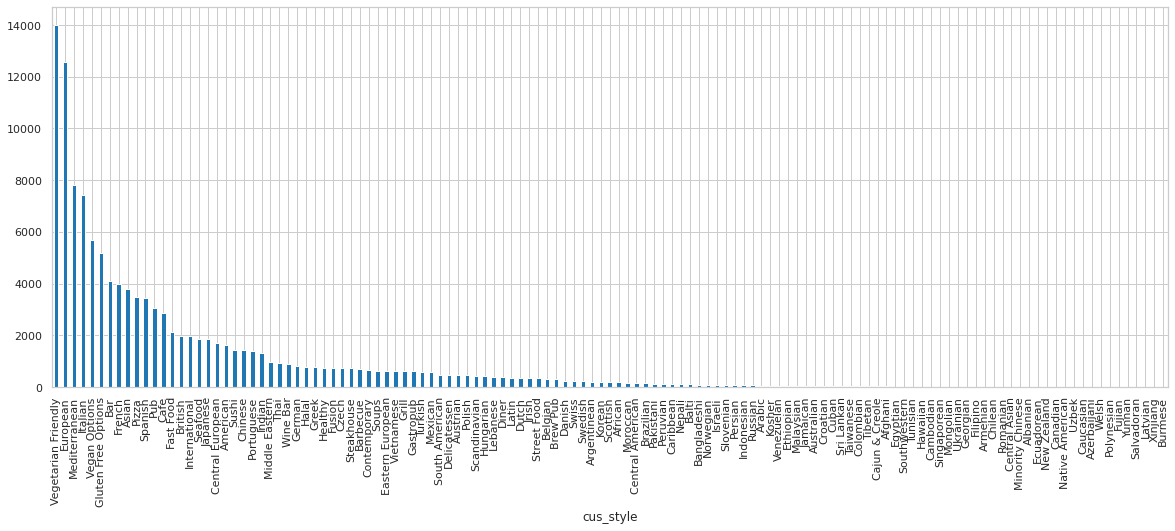

In [33]:
cus_stats[cus_stats.index!='Unknown'].plot(kind = 'bar')

Как видим, есть уникальные кухни, а есть наоборот популярные. 

Четыре идеи новых признаков - "не указана кухня (Unknown)", "есть кухня из топ-10 популярных", "есть кухня из топ-10 уникальных", "количество кухонь, представленных в ресторане'

### 2.3.2 Признаки из cuisine style.

Создадим признак - количество кухонь в ресторане, посмотрим распределения.

<AxesSubplot:>

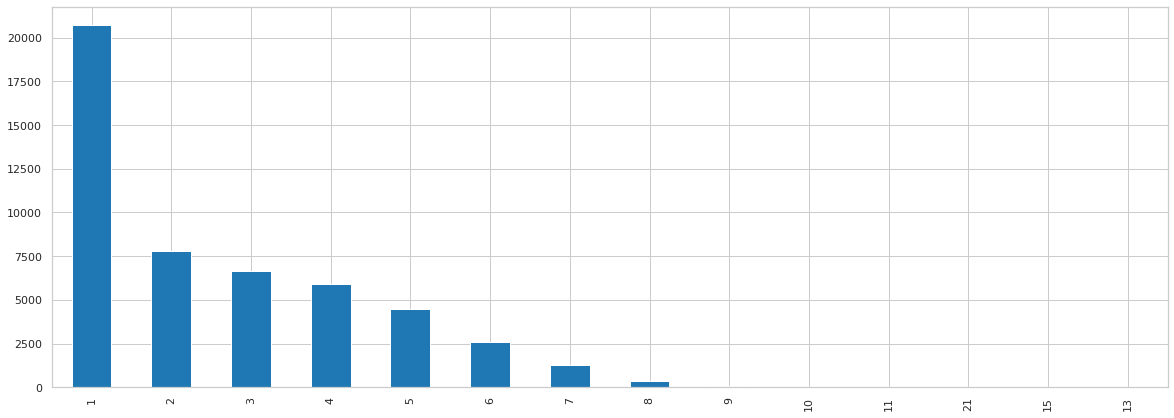

In [34]:
data['cus_num'] = data['cus_style'].apply(len)
data['cus_num'].value_counts().plot(kind = 'bar')

<AxesSubplot:xlabel='cus_num'>

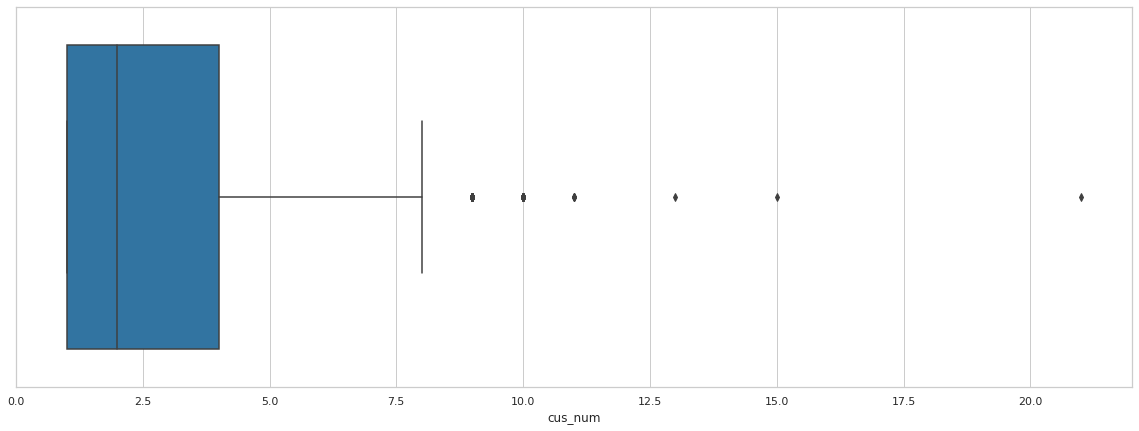

In [35]:
sns.boxplot(x = data['cus_num'])

Есть рестораны рекордсмены, где кухонь 10 и больше. Их немного. Подозрительно, посмотрим вручную.

In [36]:
def print_links(frame):
    '''
    Функция выводит готовые ссылки на TA из фрейма, который ей подали на вход
    '''
    for url in frame['URL_TA']:
        print(f'https://www.tripadvisor.com{url}')

In [37]:
print_links(data.query('cus_num > 10'))

https://www.tripadvisor.com/Restaurant_Review-g189541-d6856601-Reviews-Copenhagen_Street_Food-Copenhagen_Zealand.html
https://www.tripadvisor.com/Restaurant_Review-g187849-d1217778-Reviews-Blue_Ginger-Milan_Lombardy.html
https://www.tripadvisor.com/Restaurant_Review-g187849-d2189790-Reviews-La_Collina_d_Oro-Milan_Lombardy.html
https://www.tripadvisor.com/Restaurant_Review-g274873-d8262021-Reviews-Odprta_Kuhna-Ljubljana_Upper_Carniola_Region.html
https://www.tripadvisor.com/Restaurant_Review-g187323-d4005516-Reviews-KaDeWe_Feinschmeckerbars-Berlin.html
https://www.tripadvisor.com/Restaurant_Review-g187791-d2397684-Reviews-Meze_Bistrot-Rome_Lazio.html
https://www.tripadvisor.com/Restaurant_Review-g188590-d7231902-Reviews-Foodhallen-Amsterdam_North_Holland_Province.html


In [38]:
data.query('cus_num > 10').index[1]

'd1217778'

In [39]:
data.query('cus_num > 10').cus_style[1]

['Chinese',
 'Japanese',
 'Sushi',
 'Asian',
 'Thai',
 'Vietnamese',
 'Soups',
 'Fusion',
 'Vegetarian Friendly',
 'Vegan Options',
 'Gluten Free Options']

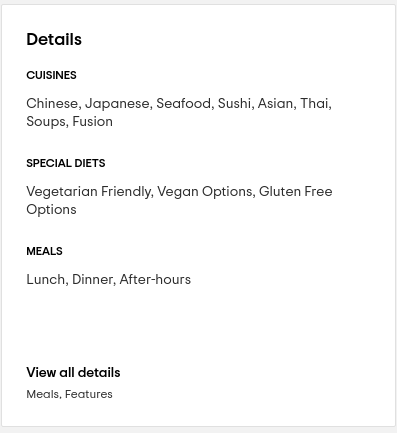

По первой ссылке ресторана нет, а во второй видно, что в данных смешаны кухни и "спецдиеты". Разделять мы их не будем. Тем не менее наши рекордсмены не ложные, но всё-таки мы удалим все рестораны, у которых кухонь больше 10 и нормализуем их (без центровки)

In [40]:
data.drop(data.query('cus_num > 10').index, inplace = True)
scaler = MinMaxScaler()
res = np.array(scaler.fit_transform(np.array(data['cus_num']).reshape(-1, 1)))
data['cus_num_norm'] = pd.Series(res.flatten(), data.index)

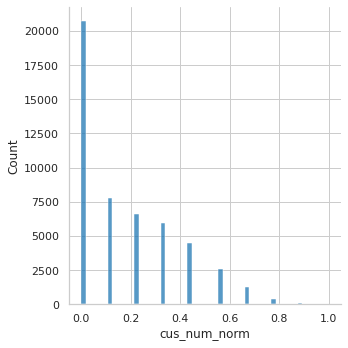

In [41]:
sns.displot(data['cus_num_norm'])

Найдём топ 10 кухонь по популярности, Unknown исключим, и все "уникальные" - то есть 10 нижних.

In [42]:
top10 = (cus.groupby('cus_style').count()
            .sort_values(by = 'ID_TA', ascending = False)
            .query('index!="Unknown"'))[0:11]
pprint(list(top10.index))

['Vegetarian Friendly',
 'European',
 'Mediterranean',
 'Italian',
 'Vegan Options',
 'Gluten Free Options',
 'Bar',
 'French',
 'Asian',
 'Pizza',
 'Spanish']


In [43]:
unique = (cus.groupby('cus_style').count()
             .sort_values(by = 'ID_TA', ascending = True)[0:11])
pprint(list(unique.index))

['Burmese',
 'Xinjiang',
 'Latvian',
 'Salvadoran',
 'Yunnan',
 'Fujian',
 'Polynesian',
 'Welsh',
 'Azerbaijani',
 'Caucasian',
 'Uzbek']


Теперь на основе этих данных создадим признаки - количество популярных кухонь в ресторане, и количество уникальных

In [44]:
data['pop_cus_count'] = data['cus_style'].apply(lambda x: len((set(x)).intersection(top10.index)))
data['unique_cus_count'] = data['cus_style'].apply(lambda x: len((set(x)).intersection(unique.index)))

## 2.4. Ranking.

Посмотрим пропуски. Их нет. А уникальных значений заметно меньше, чем всего ресторанов.

In [45]:
print(f'Пропусков: {data.ranking.isnull().sum()}')
print(f'Уникальных значений: {data.ranking.nunique()}')

Пропусков: 0
Уникальных значений: 12974


Посмотрим на выбросы.

<AxesSubplot:xlabel='ranking'>

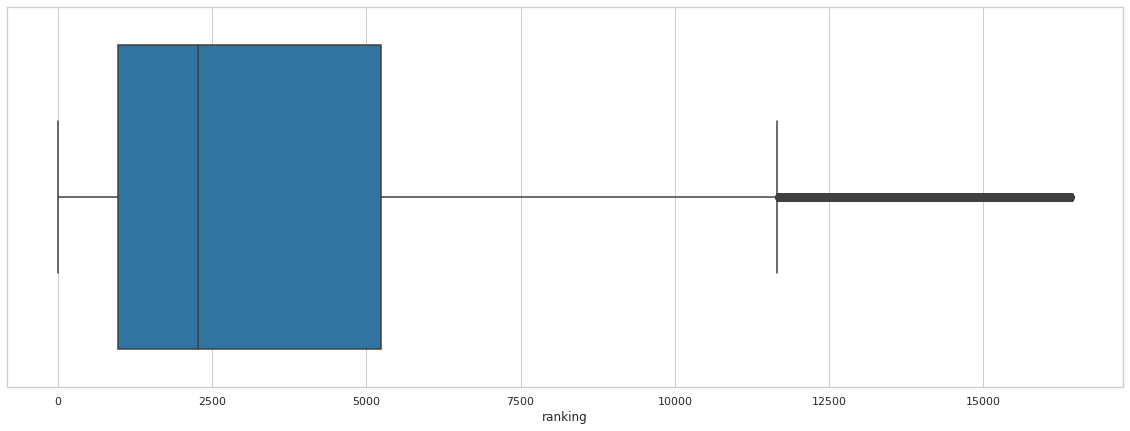

In [46]:
sns.boxplot(x = data.ranking)

Формально они есть, но с другой стороны если в городе много ресторанов, то логично что какие-то окажутся на последних местах. Проверим для последнего места в ранге.

In [47]:
print_links(data.query('ranking == ranking.max()'))

https://www.tripadvisor.com/Restaurant_Review-g186338-d720554-Reviews-Singapura_Blackfriars-London_England.html


Действительно, дно. Поэтому большие значения ranking - не испорченные данные. На графиках распределения мы ещё это увидим.


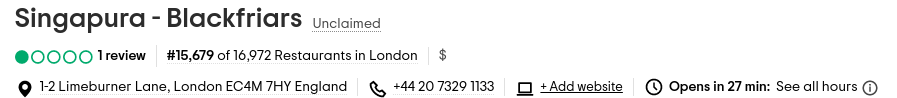

Посмотрим, например, на первыe по рангу рестораны, и на страницы этого ресторана.

In [48]:
data.query('ranking == 1')

,rest_id,city,cus_style,ranking,pricing,review_num,reviews,URL_TA,sample,rating,...,Rome,Stockholm,Vienna,Warsaw,Zurich,unknown_cus,cus_num,cus_num_norm,pop_cus_count,unique_cus_count
ID_TA,,,,,,,,,,,,,,,,,,,,,
d3929905,0.0,Hamburg,"[Lebanese, Mediterranean, Middle Eastern, Vege...",1.0,$$ - $$$,373.0,"[['Beautiful restaurant, excellent food & ser....",/Restaurant_Review-g187331-d3929905-Reviews-Re...,1.0,5.0,...,0,0,0,0,0,0,7,0.666667,4,0
d11752096,0.0,Rome,[Italian],1.0,$$ - $$$,409.0,"[['Unmissable experience', 'Magical evening'],...",/Restaurant_Review-g187791-d11752096-Reviews-F...,1.0,5.0,...,1,0,0,0,0,0,1,0.000000,1,0
d10517849,0.0,London,"[Cafe, Middle Eastern, Persian, Vegetarian Fri...",1.0,$$ - $$$,146.0,"[['Amazing cakes', 'Breakfatst'], ['01/08/2018...",/Restaurant_Review-g186338-d10517849-Reviews-R...,1.0,5.0,...,0,0,0,0,0,0,6,0.555556,3,0
d12949211,0.0,Milan,"[Italian, Mediterranean, Vegetarian Friendly, ...",1.0,$$ - $$$,103.0,"[['A Gem Worth Discovering', 'Loeve the food a...",/Restaurant_Review-g187849-d12949211-Reviews-D...,1.0,5.0,...,0,0,0,0,0,0,4,0.333333,4,0
d10428302,0.0,Madrid,"[Mediterranean, European, Spanish, Contemporar...",1.0,$$$$,352.0,"[['Absolutely divine tastes and flavours', 'Lo...",/Restaurant_Review-g187514-d10428302-Reviews-C...,1.0,5.0,...,0,0,0,0,0,0,7,0.666667,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d8479434,0.0,Edinburgh,"[European, British, Scottish]",1.0,$$$$,263.0,"[['Unforgettable', 'GROUP DINING EXPERIENCE DI...",/Restaurant_Review-g186525-d8479434-Reviews-Th...,1.0,5.0,...,0,0,0,0,0,0,3,0.222222,1,0
d7361583,0.0,Vienna,"[Austrian, European, Central European, Interna...",1.0,$$$$,241.0,"[[""Fine dining at it's best"", 'Xmas dinner'], ...",/Restaurant_Review-g190454-d7361583-Reviews-Ca...,1.0,5.0,...,0,0,1,0,0,0,6,0.555556,3,0
d12871486,0.0,Warsaw,"[Thai, Asian, Vegetarian Friendly, Gluten Free...",1.0,$,108.0,"[['Great experience', 'Best Thai food out of T...",/Restaurant_Review-g274856-d12871486-Reviews-S...,1.0,5.0,...,0,0,0,1,0,0,5,0.444444,4,0


In [49]:
print_links(data.query('ranking == 1'))

https://www.tripadvisor.com/Restaurant_Review-g187331-d3929905-Reviews-Restaurant_Hala-Hamburg.html
https://www.tripadvisor.com/Restaurant_Review-g187791-d11752096-Reviews-Federica_Barbara_of_BB_Kitchen-Rome_Lazio.html
https://www.tripadvisor.com/Restaurant_Review-g186338-d10517849-Reviews-R_H_cafe_gallery-London_England.html
https://www.tripadvisor.com/Restaurant_Review-g187849-d12949211-Reviews-Dersett-Milan_Lombardy.html
https://www.tripadvisor.com/Restaurant_Review-g187514-d10428302-Reviews-Cebo-Madrid.html
https://www.tripadvisor.com/Restaurant_Review-g190479-d805342-Reviews-Statholdergaarden-Oslo_Eastern_Norway.html
https://www.tripadvisor.com/Restaurant_Review-g189852-d7345323-Reviews-Adam_Albin_Matstudio-Stockholm.html
https://www.tripadvisor.com/Restaurant_Review-g274772-d10086671-Reviews-Gossip_Cafe-Krakow_Lesser_Poland_Province_Southern_Poland.html
https://www.tripadvisor.com/Restaurant_Review-g187265-d12337867-Reviews-Aromatic-Lyon_Rhone_Auvergne_Rhone_Alpes.html
https://ww

Рестораны действительно топовые. Многие уже не первые в своём рейтинге, но это мы не трогаем. Мы живём в 2018.

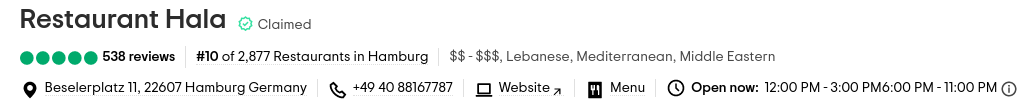

Сейчас ранк стал 10 вместо 1, но главное, что из этого следует - что ранк не глобальный, а по городам. Стоит сделать на это поправку, например стандартизировав признак. Пока сменим тип данных на целочисленный.

In [50]:
data['ranking'] = data['ranking'].astype(np.uint16)

Посмотрим на плотности распределения (по ядерной оценке) для всех городо и для топ-10 городов из списка. Они оказались похожими на нормальные, при этом отклонение сильно зависит от города. Имеет смысл центрировать и нормировать ранги ресторанов, чтобы было корректно говорить о ранге того или иного ресторана в рамках города.

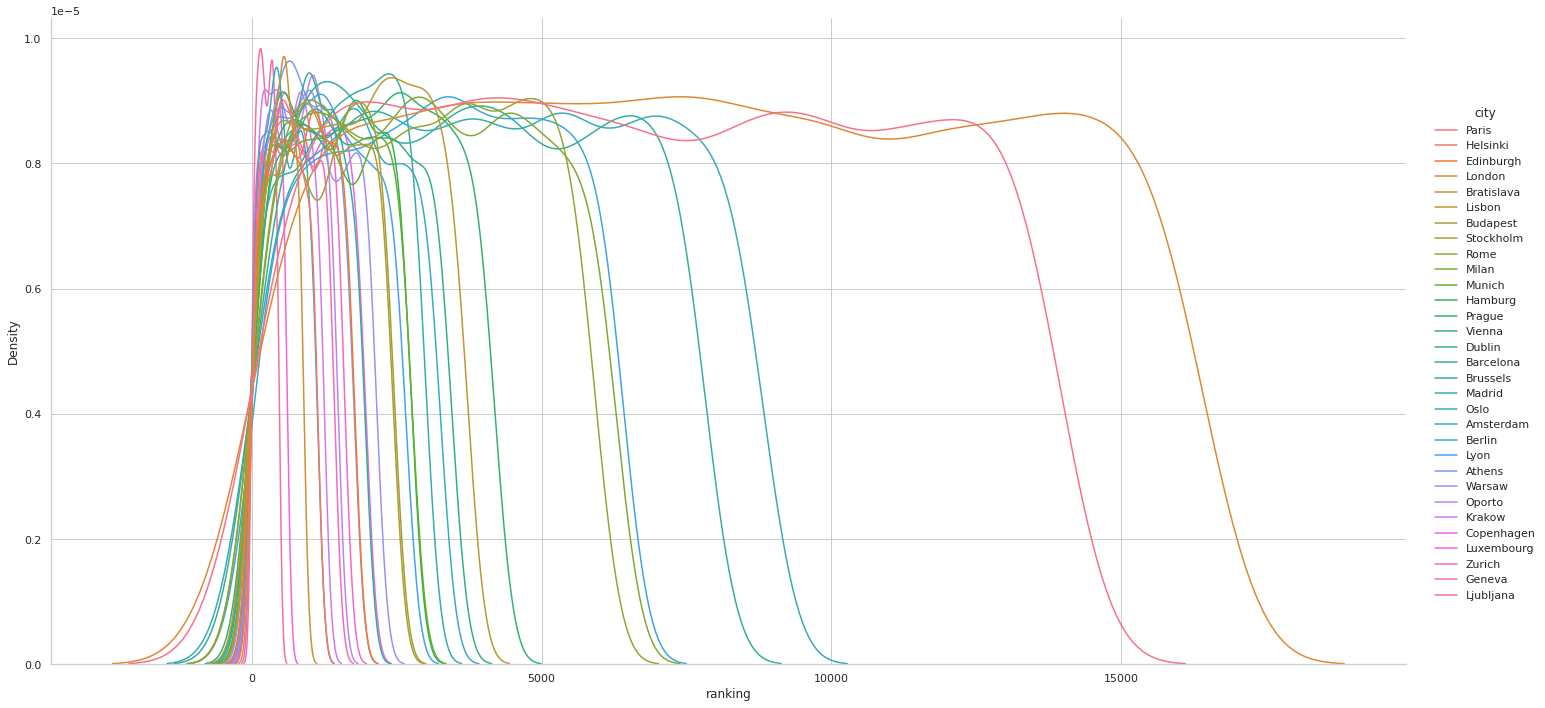

In [51]:
sns.displot(x = 'ranking', data = data, hue = 'city', 
            height = 10, aspect =2, kind = 'kde')

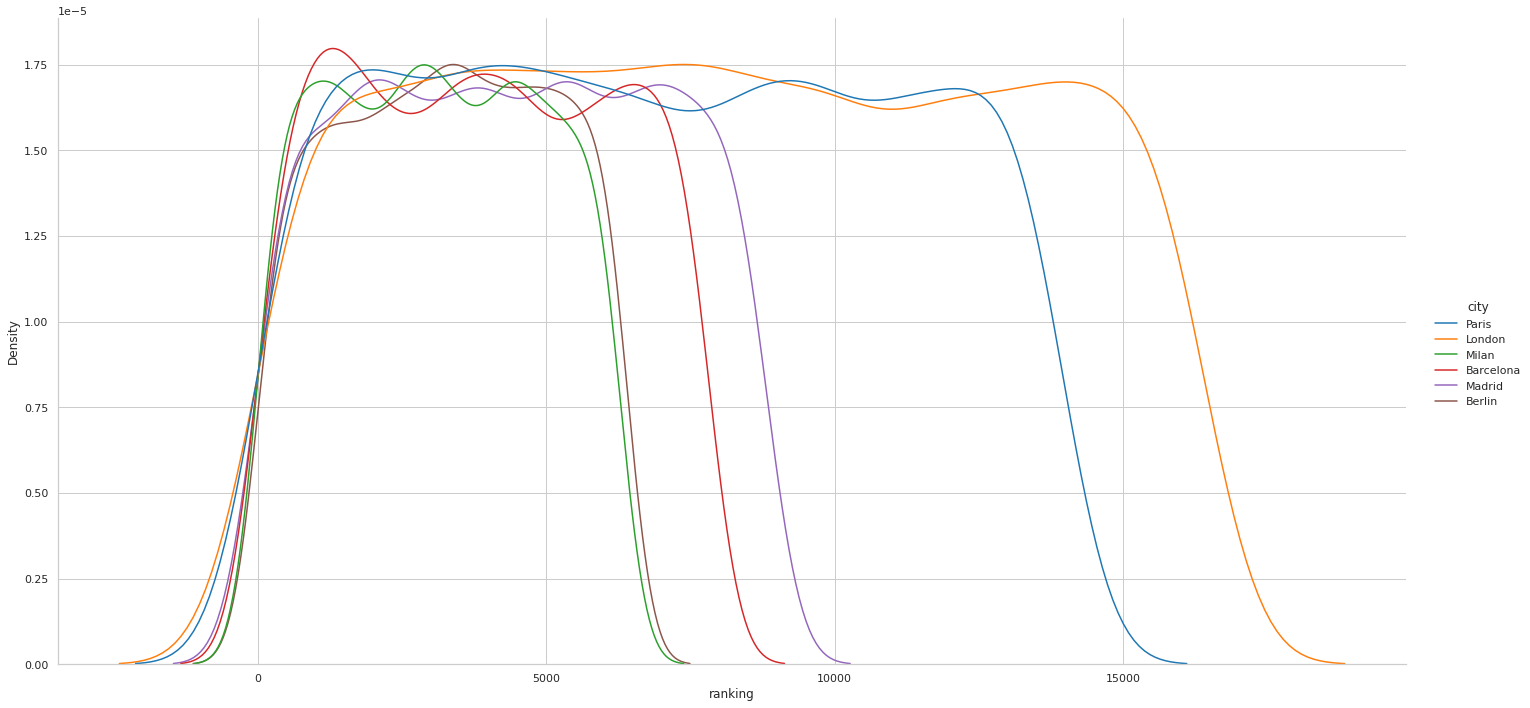

In [52]:
sns.displot(x = 'ranking', data = data[data.city.isin(data.city.value_counts()[0:6].index)], 
            hue = 'city', height = 10, aspect =2, kind = 'kde')

In [53]:
data['norm_rank'] = -1000
for one_city in data['city'].unique():
    temp_df = data.loc[data['city'] == one_city].copy()
    scaler = StandardScaler()
    res = np.array(scaler.fit_transform(np.array(temp_df['ranking']).reshape(-1, 1)))
    data.loc[data['city'] == one_city, 'norm_rank'] = pd.Series(res.flatten(), temp_df.index)

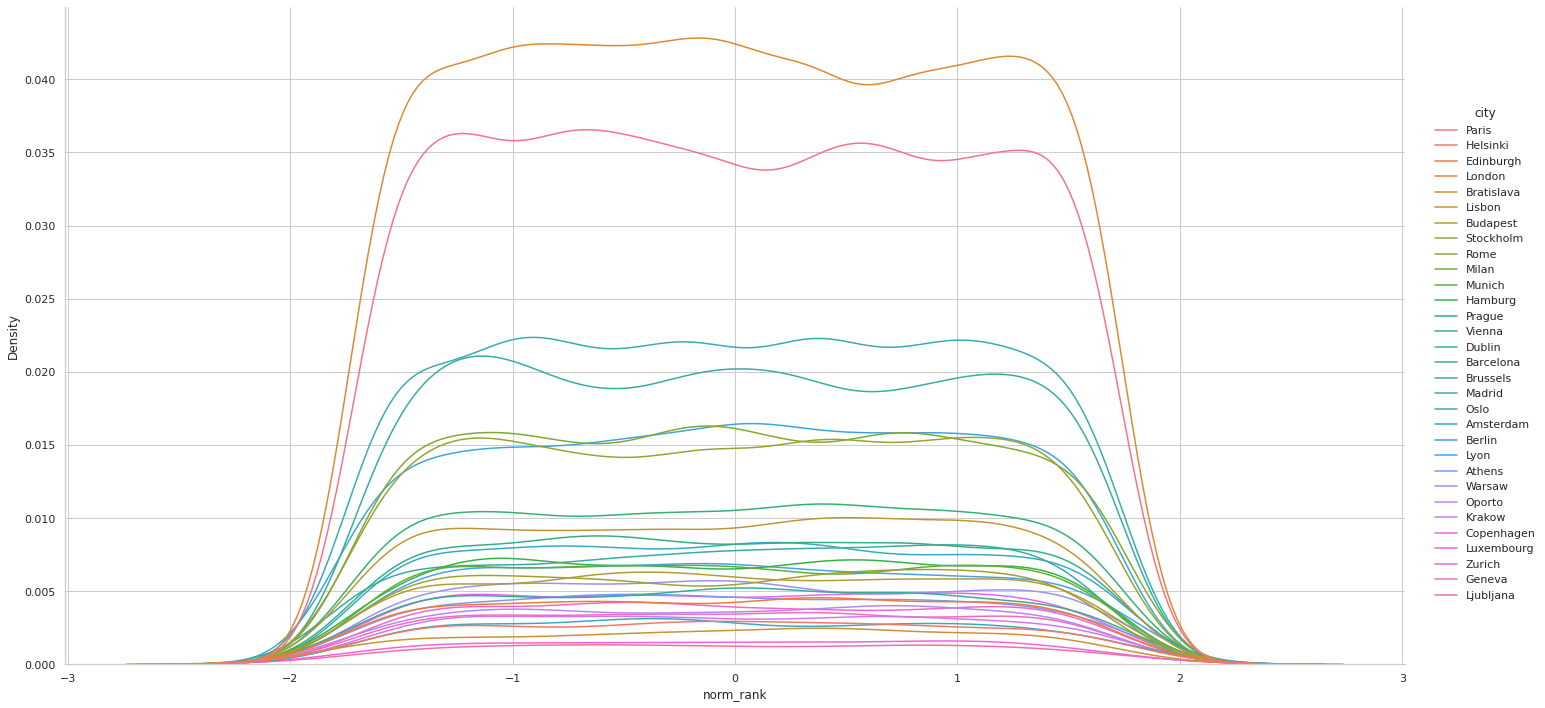

In [54]:
sns.displot(x = 'norm_rank', data = data, hue = 'city', 
            height = 10, aspect = 2, kind = 'kde')

Вот так гораздо лучше

## 2.5. Rating.

Это наша целевая переменная. Пока просто рассмотрим значения, пропуски, распределение.

Число пропусков в Rating: 0
Уникальные значения в Rating: [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


<AxesSubplot:xlabel='rating'>

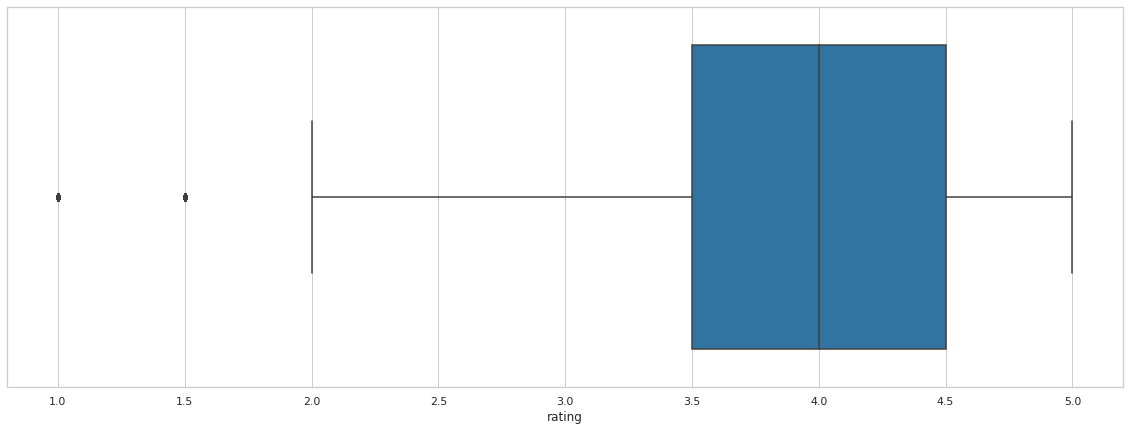

In [55]:
data_train = data.query('sample == 1')
# В тесте мы сами заполнили всё нулями.
print(f'Число пропусков в Rating: {data_train.rating.isnull().sum()}')
print(f'Уникальные значения в Rating: {sorted(list(data_train.rating.unique()))}')
sns.boxplot(x = 'rating', data = data_train.query('sample == 1'))

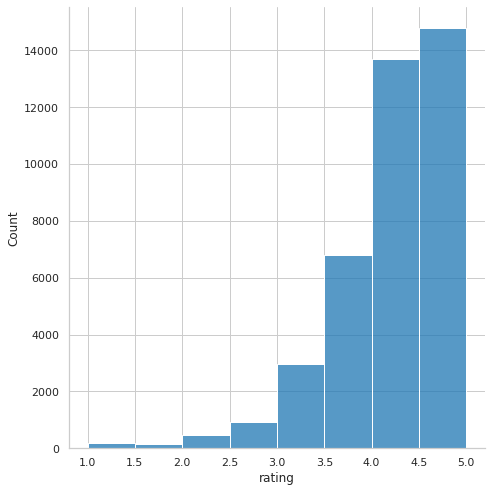

In [56]:
sns.displot(x = 'rating', data = data_train, height = 7, binwidth=0.5)

Распределение смещено в сторону положительных оценок.

## 2.6. Reviews.
### 2.6.1. Обработка.
Два последних отзыва о ресторане. Не все заполнены. Есть пара NaN, но на самом деле пропуски в виде строки '[[], []]'. Заполним NaN этой строко. Преобразуем строки в списки при помощи eval. Если просто применить eval к столбцу, то вылезет ошибка Name

In [57]:
data.reviews.isnull().sum()

2

In [58]:
data.reviews.fillna('[[], []]', inplace = True)

In [59]:
def eval_with_nans(review):
    '''
    Функция обрабатывает строки в столбце Reviews, преобразуя их в 
    список вида [[Отзыв1, Отзыв2], [Дата1, Дата2]]
    Если в стоке есть nan в качестве отзыва или даты, то eval его не поймёт,
    выкинет исключение. В этом случае мы элемент nan заменим на строку "nan" 
    и повторим попытку.
    '''
    try:
        result = eval(review)
        return result
    except NameError:
        review = review.replace('nan', '"nan"')
        return eval_with_nans(review)

In [60]:
data['reviews'] = data['reviews'].apply(eval_with_nans)

Посмотрим на полноту данных по датам.

In [61]:
review1 = data['reviews'].apply(lambda x: x[1][0] if (len(x)>1 and len(x[1])>1) else 0)
review1.value_counts()

0             13783
01/07/2018      597
01/03/2018      519
01/06/2018      486
01/04/2018      457
              ...  
12/30/2013        1
09/20/2014        1
12/18/2014        1
06/19/2014        1
03/31/2010        1
Name: reviews, Length: 1576, dtype: int64

In [62]:
review2 = data['reviews'].apply(lambda x: x[1][1] if (len(x)>1 and len(x[1])>1) else 0)
review2.value_counts()

0             13783
01/03/2018      250
01/04/2018      218
12/30/2017      209
01/01/2018      203
              ...  
11/28/2012        1
10/13/2012        1
08/28/2012        1
11/14/2007        1
08/03/2013        1
Name: reviews, Length: 2070, dtype: int64

Дырок много. При этом иногда из 2 дат есть только одна. При отсутствии даты будем считать её pd.to_datetime(0), т.е. 0 в формате unix timestamp, при этом при подсчёте разности по времени будем возвращать nan.
### 2.6.2. Даты отзывов.
Сделаем из дат 2 признака - дата последнего отзыва и время между отзывами, в формате unix timestamp (секунды), делённом на $10^{16}$.

In [63]:
data['last_review'] = data['reviews'].apply(lambda x: max(list(map(pd.to_datetime, x[1]))) 
                                            if x[1]!=[] else pd.to_datetime(0)).astype(np.int64)
data['first_review'] = data['reviews'].apply(lambda x: min(list(map(pd.to_datetime, x[1]))) 
                                             if x[1]!=[] else pd.to_datetime(0)).astype(np.int64)

In [64]:
def calculate_dt_nans(record):
    '''
    считаем разницу по времени, если одной из дат нет, то возвращаем None
    '''
    if (record['first_review'] == 0) or (record['last_review'] == 0):
        return None
    else:
        return (record['last_review'] - record['first_review'])/(10**16)

In [65]:
data['review_days_delta'] = data.apply(calculate_dt_nans, axis = 1)
data['review_days_delta'].isnull().sum()

8106

Много дырок, конечно, но как есть. Сделаем dummy-переменные, отмечающие отсутствие первой даты, второй даты, и времени между отзывами.

In [66]:
data['no_first_review'] = data['first_review'].apply(lambda x: 0 if x!=0 else 1)
data['no_second_review'] = data['last_review'].apply(lambda x: 0 if x!=0 else 1)
data['no_time_delta'] = data['review_days_delta'].apply(lambda x: 1 if pd.isna(x) else 0)

<AxesSubplot:xlabel='review_days_delta'>

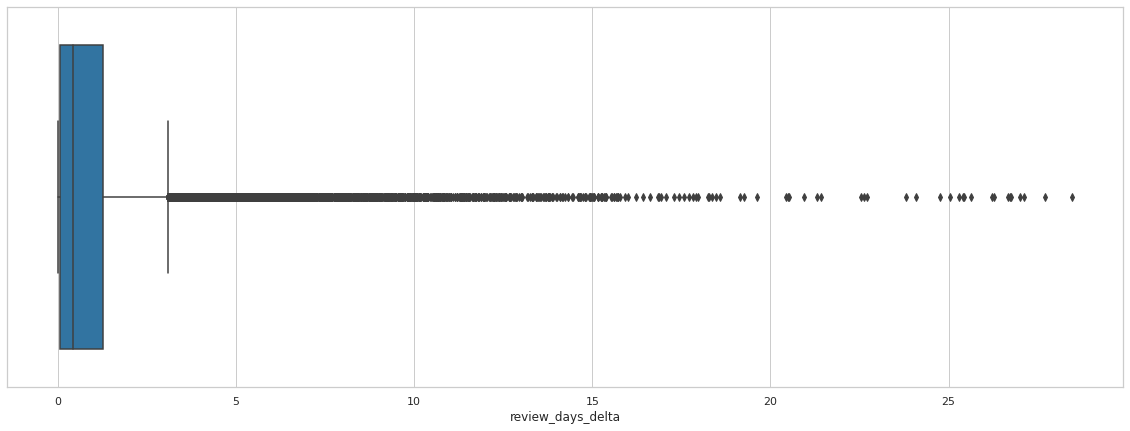

In [67]:
sns.boxplot(x = data['review_days_delta'])

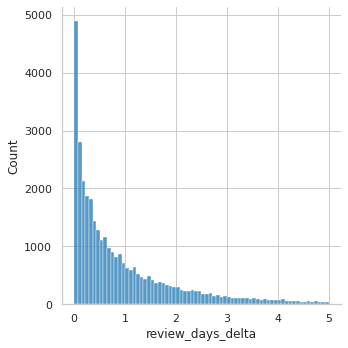

In [68]:
sns.displot(data.query('review_days_delta!=0 & review_days_delta<5')['review_days_delta'])

Заполним пропуски в review_days_delta нулями

In [69]:
data['review_days_delta'].fillna(0, inplace = True)

### 2.6.3. Обработка текстовых данных в отзывах.

Попробуем обработать текстовую информацию в отзывах. Идея следующая - посчитать, какие слова часще всего встречаются в отзывах ресторанов с рейтингом 4,4.5 ("хорошие"), какие в рейтинге 3-4 ("средние") и в рейтинге 0-3("плохие"). Каждое слово может попасть только в одну группу (по построению этих групп, см.код). Дальше считаем сколько в отзывах есть этих слов. Лучший предик получился, если не давать в модель количество "средних" слов.

In [70]:
def search_words(rating_list, frame):
    '''
    Функция проходит по датафрейму и формирует список из 100 слов, которые 
    встречаются в отзывах на рестораны с рейтингом из rating list. 
    Возвращает список слов-строк.
    '''
    words = (frame[frame['rating'].isin(rating_list)]['reviews']
             .apply(lambda x: x[0] if (len(x) > 0) else []))
    words = words.apply(lambda x: str(x[0]).lower() + ' ' 
                        + str(x[1]).lower() if len(x)>1 else '')
    words_str = ''
    for phrase in words:
        if len(phrase) > 0:
            words_str+=phrase+' '
    words_str = re.sub('[\u263a-\U0001f645!\#\%\&\@\*\"\'\?\`]','', words_str) 
    words_ls = re.split('[\s+(\.\.\.)/]', words_str)
    words_ls = list(filter(lambda x: len(x)>3, words_ls))
    counter = collections.Counter(words_ls)
    result = []
    for word in counter.most_common(100):
        result.append(word[0])
    return result

In [71]:
def rate_review(record, words):
    '''
    Функция получает строку из фрейма record, считает сколько в
    отзывах есть слов из words и возвращает это число.
    '''
    reviews = str(record['reviews'][0]).lower()
    counter = 0
    for word in words:
        counter += len(re.findall(word, reviews))
    return counter

In [72]:
good = set(search_words([4.5,5], data))
#average = set(search_words([3,3.5], data))
bad = set(search_words([0,0.5,1,1.5,2,2.5], data))
good_new = good - bad #- average
bad_new = bad - good #- average
data['good_word_rating'] = data.apply(rate_review, axis = 1, words = good_new)
data['bad_word_rating'] = data.apply(rate_review, axis = 1, words = bad_new)

In [73]:
good_new

{'beautiful',
 'brilliant',
 'cocktails',
 'cool',
 'dining',
 'fabulous',
 'favourite',
 'french',
 'home',
 'japanese',
 'london',
 'love',
 'must',
 'outstanding',
 'place,',
 'real',
 'superb',
 'surprise',
 'taste',
 'town',
 'vegan',
 'yummy'}

In [74]:
bad_new

{'average',
 'avoid',
 'chinese',
 'choice',
 'decent',
 'disappointing',
 'dont',
 'drinks',
 'expensive',
 'fast',
 'here',
 'location',
 'menu',
 'money',
 'pleasant',
 'poor',
 'reasonable',
 'rude',
 'stop',
 'terrible',
 'worst',
 'your'}

## 2.7. Number of Reviews.
Сколько всvего отзывов есть о ресторане

In [75]:
print(f'Число пропусков в review_num: {data.review_num.isnull().sum()}')
print(f'Число пропусков в review_num: {round(100*data.review_num.isnull().sum()/len(data),2)}%')

Число пропусков в review_num: 3200
Число пропусков в review_num: 6.41%


Пропусков заметное количество. Посмотрим на выбросы.

<AxesSubplot:xlabel='review_num'>

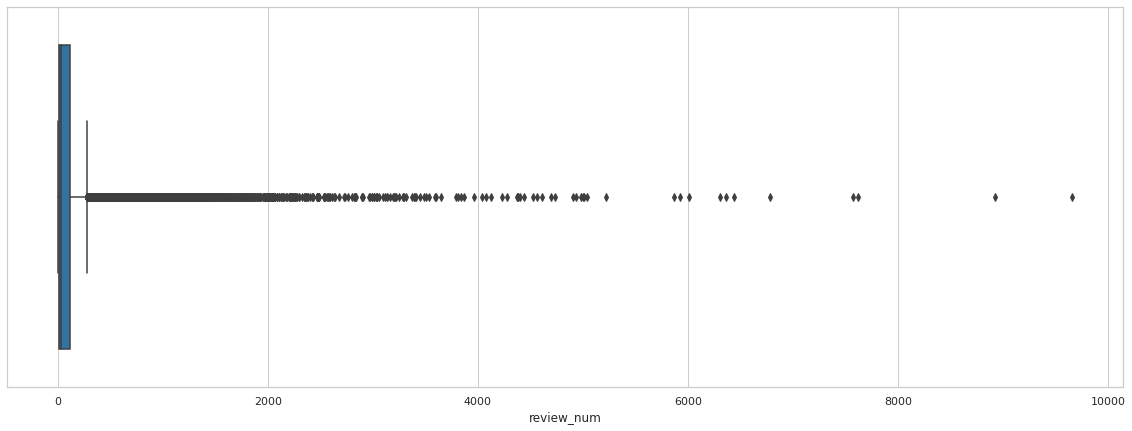

In [76]:
sns.boxplot(x = data.review_num)

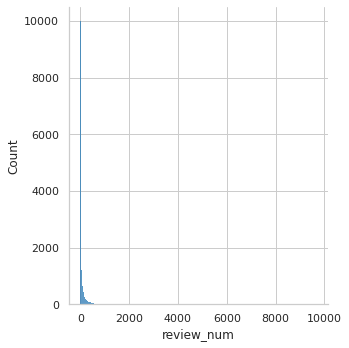

In [77]:
sns.displot(data.review_num)

Не самая информативная попытка... Выбросы портят картинку, но они, возможно и не выбросы. Попробуем сократить разброс, взяв логарифм оп основанию 10.

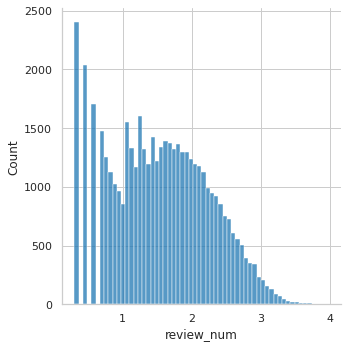

In [78]:
sns.displot(np.log10(data.review_num))

Так лучше. Около нуля у нас есть пик, это во многом из-за пропусков.

In [79]:
print(f'ресторанов с числом отзывов больше {int(10**3.5)}: {(np.log10(data.review_num)>3.5).sum()}')

ресторанов с числом отзывов больше 3162: 58


Я бы всё-таки проверил число ревью хотя бы у топ-50 ресторанов. Пошли парсить TA.

suspicious_rev = data[(np.log10(data.review_num)>3.5)]

In [80]:
def count_reviews(rest_record):  
    '''
    Лезем на TA по ссылке из записи rest_record, смотрим сколько сейчас отзывов, 
    сравниваем с данными из фрейма. Если сейчас отзывов больше, то запись скомпроментирована.
    '''
    rev_pattern = re.compile('[\d,]+ review')
    url = rest_record.URL_TA
    r = requests.get('https://www.tripadvisor.com' + url)
    soup = BeautifulSoup(r.text, 'html.parser')
    tag = soup.find('div', class_ ='ppr_rup ppr_priv_top_info')
    if tag is not None:
        rev_str = rev_pattern.search(tag.text)
        if rev_str is not None:
            result = int(re.sub('\D', '', rev_str[0]))
            print(f'Ресторан {rest_record.name}: найдено отзывов {result},',
                  f'а в фрейме их {rest_record.review_num},',
                  f'разница {result - rest_record.review_num}')
            if (result - rest_record.review_num) < 0:
                print(f'Доверять данным из фрейма для ресторана {rest_id} нельзя.')
        else: print(tag.text)
    else:
        print(f'Нет страницы ресторана по ссылке https://www.tripadvisor.com{url}')

In [81]:
suspicious_rev = data[(np.log10(data.review_num)>3.5)]
_ = suspicious_rev.apply(count_reviews, axis = 1)

Ресторан d720945: найдено отзывов 6008, а в фрейме их 4567.0, разница 1441.0
Ресторан d953797: найдено отзывов 3935, а в фрейме их 3190.0, разница 745.0
Ресторан d717275: найдено отзывов 6407, а в фрейме их 4996.0, разница 1411.0
Ресторан d1516182: найдено отзывов 6661, а в фрейме их 4382.0, разница 2279.0
Ресторан d3666269: найдено отзывов 12715, а в фрейме их 5037.0, разница 7678.0
Ресторан d776287: найдено отзывов 6334, а в фрейме их 5011.0, разница 1323.0
Ресторан d1009022: найдено отзывов 6239, а в фрейме их 4608.0, разница 1631.0
Ресторан d4041036: найдено отзывов 6225, а в фрейме их 4977.0, разница 1248.0
Ресторан d694788: найдено отзывов 8751, а в фрейме их 6437.0, разница 2314.0
Ресторан d700845: найдено отзывов 4601, а в фрейме их 3647.0, разница 954.0
Ресторан d2527526: найдено отзывов 6263, а в фрейме их 3538.0, разница 2725.0
Ресторан d1015650: найдено отзывов 3950, а в фрейме их 3289.0, разница 661.0
Ресторан d794412: найдено отзывов 3811, а в фрейме их 3221.0, разница 59

Вывод - данные корректны! Отцентруем и нормируем их, посмотрим как будет лучше предикт. Разберёмся с пропусками. Их больше 2500, так что парсинг ТА займёт очень много времени. Плюс количество отзывов на сегодняшний день стабильно больше, чем на дату составления фрейма, можем влететь на некорректные данные. Посмотрим несколько пропущенных ресторанов.

In [82]:
sample = data[data.review_num.isnull()].head(10)
_ = sample.apply(count_reviews, axis = 1)

Ресторан d8286886: найдено отзывов 1, а в фрейме их nan, разница nan
Нет страницы ресторана по ссылке https://www.tripadvisor.com/Restaurant_Review-g187514-d13202032-Reviews-Wan-Madrid.html
Ресторан d7124128: найдено отзывов 2, а в фрейме их nan, разница nan
Ресторан d12032989: найдено отзывов 3, а в фрейме их nan, разница nan
Ресторан d10088997: найдено отзывов 1, а в фрейме их nan, разница nan
Ресторан d12644341: найдено отзывов 2, а в фрейме их nan, разница nan
Ресторан d12204689: найдено отзывов 14, а в фрейме их nan, разница nan
Ресторан d4802788: найдено отзывов 1, а в фрейме их nan, разница nan
Ресторан d12530776: найдено отзывов 9, а в фрейме их nan, разница nan
Ресторан d753088: найдено отзывов 1, а в фрейме их nan, разница nan


Вывод - отзывы всё-таки есть, но их мало. Возможно вообще не было на тот момент. Примем волевое решение заменить пропущенные значения нулями, и создать dummy-переменную для обозначения отсутствия отзывов.

In [83]:
data['no_review'] = data['review_num'].apply(pd.isna).astype(np.uint8)
data['review_num'].fillna(0, inplace = True)
data['review_num'] = data['review_num'].astype(np.uint16)

Введём в качестве признака с меньшим разбросом десятичный логарифм количества отзывов. Еще отцентруем и нормируем количество отзывов, попробуем на модели все три варианта. Поскольку логарифм нуля не определён, то присваивам нулевым значениям минус единицу. Это значение уникальное для нуля, потому что оно соответствует количеству отзывов 0.1, чего не бывает.

In [84]:
data.query('0<review_num<1').nunique()

rest_id             0
city                0
cus_style           0
ranking             0
pricing             0
                   ..
no_second_review    0
no_time_delta       0
good_word_rating    0
bad_word_rating     0
no_review           0
Length: 56, dtype: int64

In [85]:
data['review_num_log'] = data['review_num'].apply(lambda x: np.log10(x) if x!=0 else -1)
scaler = StandardScaler()
res = np.array(scaler.fit_transform(np.array(data['review_num_log']).reshape(-1, 1)))
data['review_num_norm_log'] = pd.Series(res.flatten(), data.index)

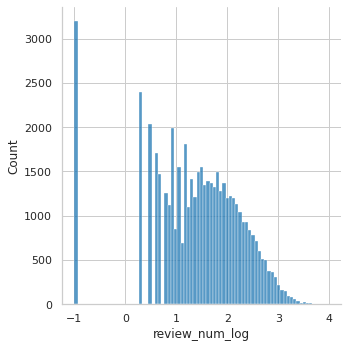

In [86]:
sns.displot(data.review_num_log)

## 2.7. Pricing (ex Price Range).
Уровень цен в ресторанах.

In [87]:
print(f'Число пропусков в pricing: {data.pricing.isnull().sum()}')
print(f'Число пропусков в pricing: {round(100*data.pricing.isnull().sum()/len(data),2)}%')
print(f'Уникальные значения в pricing: {data.pricing.unique()}%')

Число пропусков в pricing: 17344
Число пропусков в pricing: 34.72%
Уникальные значения в pricing: ['$$ - $$$' '$$$$' '$' nan]%


Очень много пропусков... TA парсить долго, да и с 2018 (последний отзыв в сете) что-то могло поменяться, кризис, инфляция... Посмотрим распределение. Уникальных значений всего 4, поэтому график излишний.

In [88]:
data['pricing'].value_counts()

$$ - $$$    23023
$            7809
$$$$         1780
Name: pricing, dtype: int64

In [89]:
data['pricing'].value_counts(normalize = True)

$$ - $$$    0.705967
$           0.239452
$$$$        0.054581
Name: pricing, dtype: float64

Очень дорогих ресторанов немного, а самые распространённые - средней ценовой категории. Заменим пропуски в pricing модой.

In [90]:
data['pricing'].mode()[0]

'$$ - $$$'

In [91]:
data.loc[data['pricing'].isnull(), 'pricing'] = data['pricing'].mode()[0]

In [92]:
data['pricing'].value_counts(normalize = True)

$$ - $$$    0.808051
$           0.156318
$$$$        0.035631
Name: pricing, dtype: float64

Сразу растащим на dummy.

In [93]:
data = pd.merge(data, pd.get_dummies(data['pricing']), 
                                     left_index=True, right_index=True)

# 3. Корреляции и распределение рейтинга. 
Посмотрим как коррелируют количественные признаки между собой. Уже созданные новые признаки не рассматриваем, понятно что они будут коррелировать с "родителями".

<AxesSubplot:>

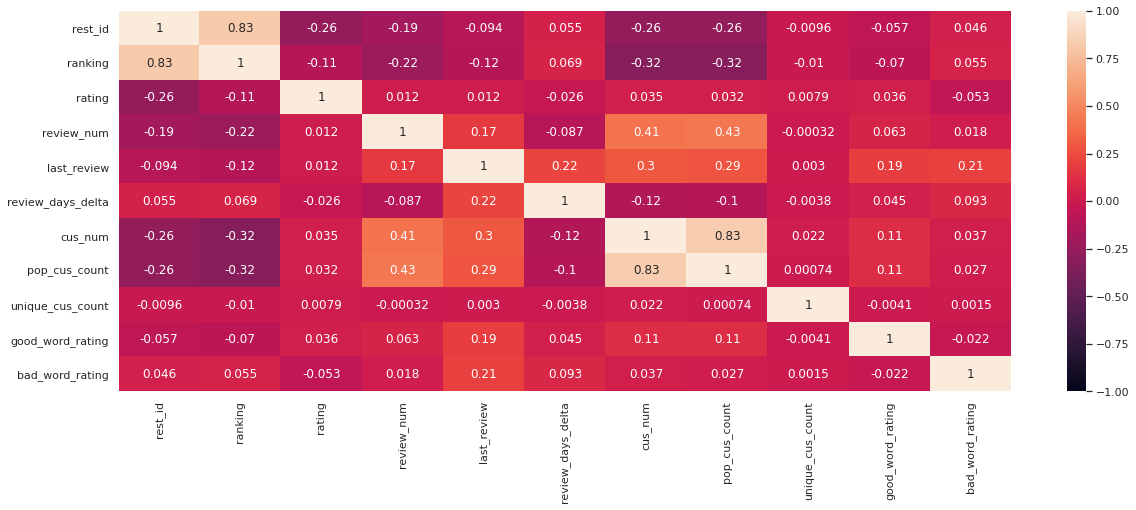

In [94]:
sns.heatmap(data[['rest_id','ranking', 'rating', 'review_num', 
                  'last_review', 'review_days_delta', 'cus_num', 
                  'pop_cus_count', 'unique_cus_count', 'good_word_rating', 
                  'bad_word_rating']].corr(),
                   vmin = -1, vmax = 1, annot = True)

Между rest_id и ranking очень сильная корреляция! Значит непонятный признак rest_id можно наконец выкинуть. Ещё есть некоторая корреляция между ранкнгом и количеством отзывов. У ресторанов, чей ранг высокий (топ-200 где-то), отзывов больше всех.

Также видим корреляцию между признаками cus_num и pop_cus_count, а также last_review коррелирует много с чем. От такого может помочь разложение по главным компонентам (PCA). Но не помогло)) Поэтому в финальной функции предобработки его нет.

In [95]:
# Стандартизируем признаки для PCA
scaler = StandardScaler()
res = np.array(scaler.fit_transform(np.array(data['cus_num']).reshape(-1, 1)))
data['cus_num_std'] = pd.Series(res.flatten(), data.index)

scaler = StandardScaler()
res = np.array(scaler.fit_transform(np.array(data['pop_cus_count']).reshape(-1, 1)))
data['pop_cus_count_std'] = pd.Series(res.flatten(), data.index)

scaler = StandardScaler()
res = np.array(scaler.fit_transform(np.array(data['last_review']).reshape(-1, 1)))
data['last_review_std'] = pd.Series(res.flatten(), data.index)

scaler = StandardScaler()
res = np.array(scaler.fit_transform(np.array(data['review_days_delta']).reshape(-1, 1)))
data['review_days_delta_std'] = pd.Series(res.flatten(), data.index)
# Теперь PCA
pca = PCA(n_components=1)
x = data[['pop_cus_count_std','cus_num_std', 'last_review_std','review_days_delta_std']]
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1'])

data = data.reset_index().join(principalDf).set_index('ID_TA')
# Выбрасываем признаки, так или иначе вошедшие в разложение
todrop=['pop_cus_count_std','cus_num_std', 'review_num_log', 'review_num_norm_log',
        'last_review_std','review_days_delta','pop_cus_count',
        'last_review','review_days_delta_std', 'cus_num',
        'review_days_delta','review_days_delta_std']

<AxesSubplot:>

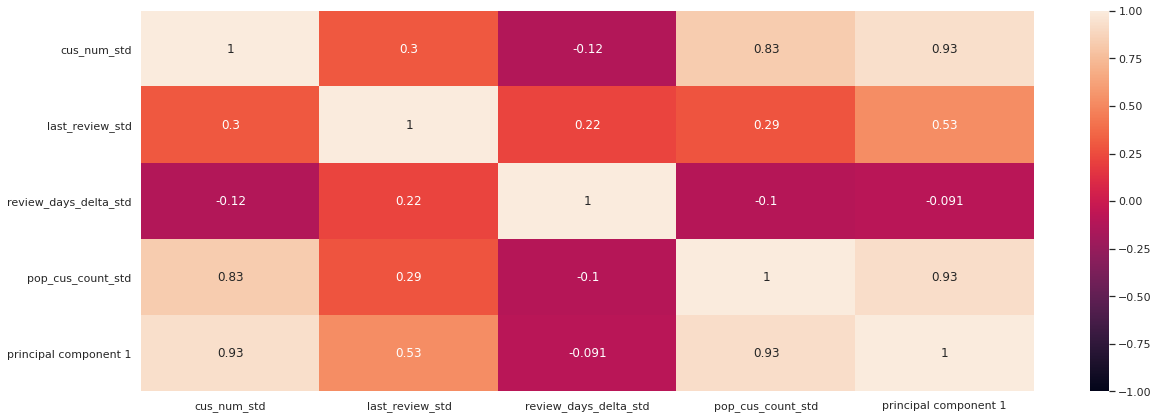

In [96]:
sns.heatmap(data[['cus_num_std','last_review_std', 
                  'review_days_delta_std', 'pop_cus_count_std', 
                  'principal component 1']].corr(),
                 vmin = -1, vmax = 1, annot = True)

Посмотрим распределение рейтинга по городам

<AxesSubplot:xlabel='city'>

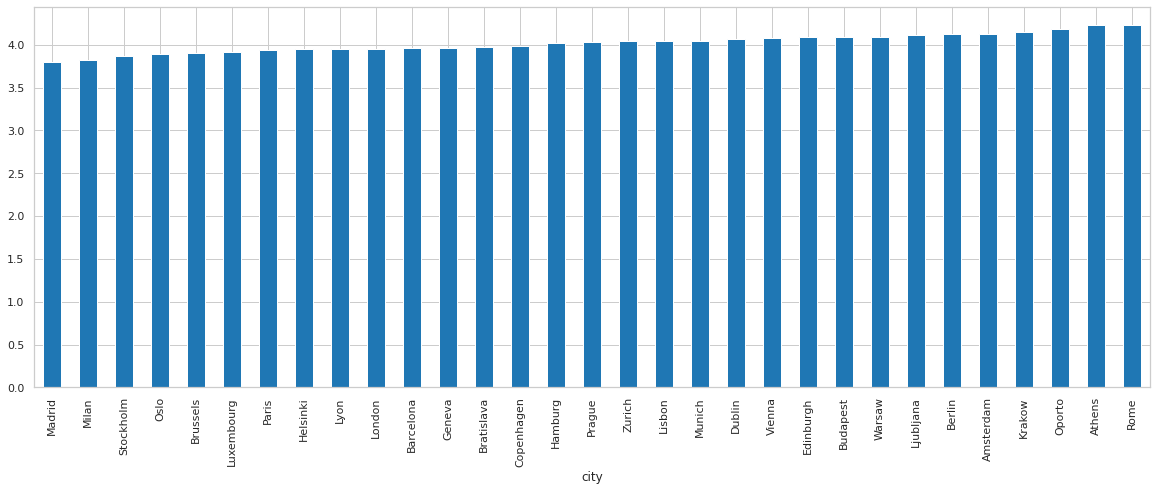

In [97]:
data.query('sample == 1').groupby('city')['rating'].mean().sort_values().plot(kind = 'bar')

В Риме лучшие рестораны. А в Мадриде худшие. Мы ещё увидим dummy для Рима в распределении важности фичей для модели.


<AxesSubplot:xlabel='cus_style'>

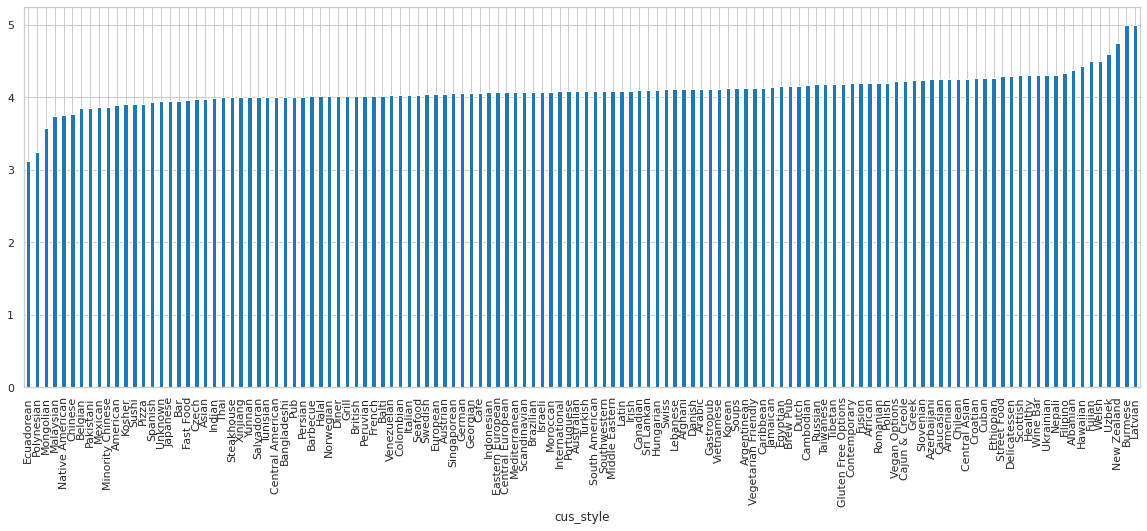

In [98]:
data.query('sample == 1').explode('cus_style').groupby('cus_style')['rating'].mean().sort_values().plot(kind = 'bar')

Латвийская кухня - лучшая)). Это из-за того, что она крайне редкая (видели по распрделению кухни), и ресторан, в котором её подают, имеет рейтинг 5.

# 4. Загрузка внешних данных
## 4.1. Данные по городам
Нагуглил статистику по городам. Быстрее было бы вбить её руками, или спереть с блокнотов других студентов, но так неинтересно. Файл global-city-population-estimates.xls

In [99]:
cities = data.city.unique()
city_stats = pd.read_excel(DATA_DIR+'/global-city-population-estimates.xls', 
                           sheet_name='CITIES-OVER-300K', 
                           usecols=['Urban Agglomeration', 'Country or area', '2020'])
        
city_stats.columns = ['country', 'city', 'pop']
city_data = pd.DataFrame(columns = ['country', 'city', 'pop'])
for city in cities:
    city_data = city_data.append(city_stats[city_stats['city'].str.contains(city)])
city_data.city = cities
city_data.set_index('city', inplace = True)

data['city_pop'] = data['city'].apply(lambda x: city_data.loc[x, 'pop'])
data['country'] = data['city'].apply(lambda x: city_data.loc[x, 'country'])

data = pd.merge(data, pd.get_dummies(data['country']), left_index=True, right_index=True)

<AxesSubplot:xlabel='city'>

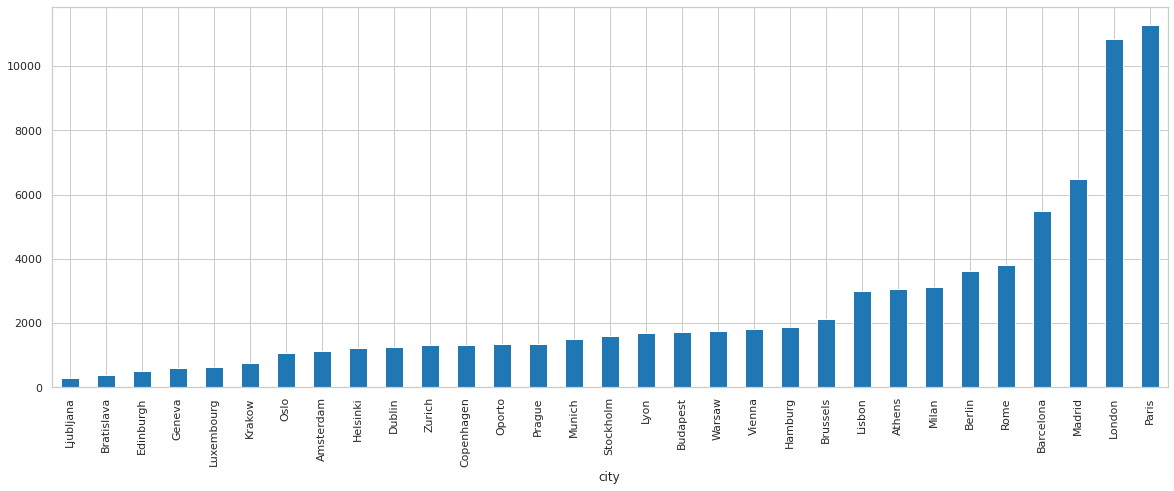

In [100]:
data.groupby('city').mean()['city_pop'].sort_values().plot(kind = 'bar')

<AxesSubplot:xlabel='country'>

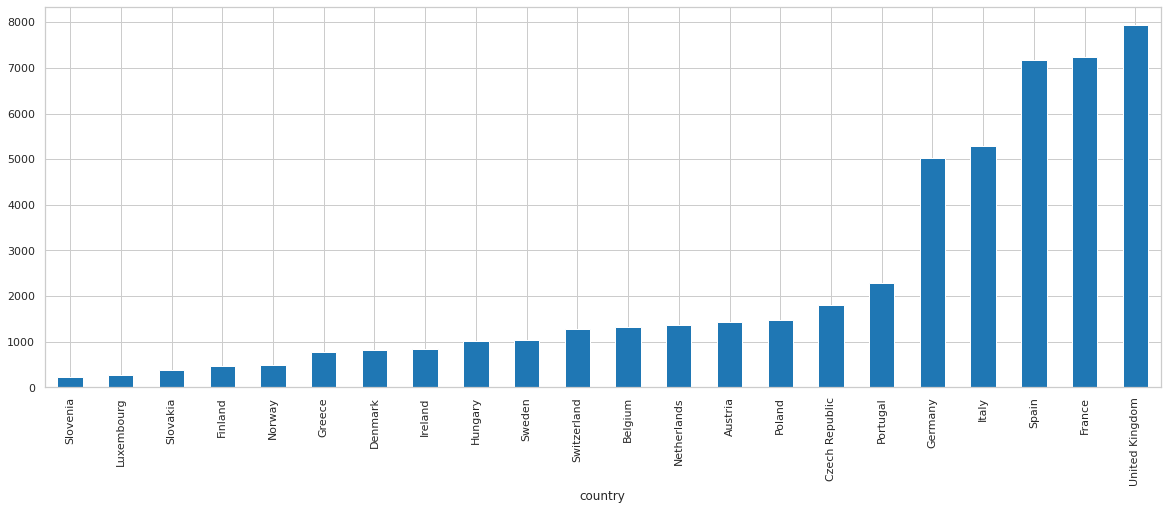

In [101]:
data.groupby('country').count()['URL_TA'].sort_values().plot(kind='bar')

# 5. Модель.

Выбросим все колонки, в которых у нас объекты

In [102]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

Пока посмотрим как модель работает на трейне.

In [103]:
X = data.query('sample==1').drop(['sample', 'rating']+todrop, axis=1)
y = data.query('sample==1')['rating']

  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)  

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
  
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
  
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [104]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20741943554843872


Посмотрим чего мы там напрогнозировали.

In [105]:
y_test

ID_TA
d3801305     4.0
d11979613    4.5
d13133990    5.0
d7277861     3.0
d7253729     3.0
            ... 
d6153959     4.0
d1337263     4.0
d12653008    4.0
d9844733     4.5
d10373909    4.0
Name: rating, Length: 9992, dtype: float64

In [106]:
result = pd.DataFrame(data = y_test)
result.columns = ['test']
result['pred'] = y_pred
result['diff'] = result['pred'] - result['test']

In [107]:
result

,test,pred,diff
ID_TA,,,
d3801305,4.0,3.875,-0.125
d11979613,4.5,4.385,-0.115
d13133990,5.0,5.000,0.000
d7277861,3.0,2.860,-0.140
d7253729,3.0,3.080,0.080
...,...,...,...
d6153959,4.0,4.200,0.200
d1337263,4.0,4.080,0.080
d12653008,4.0,3.990,-0.010


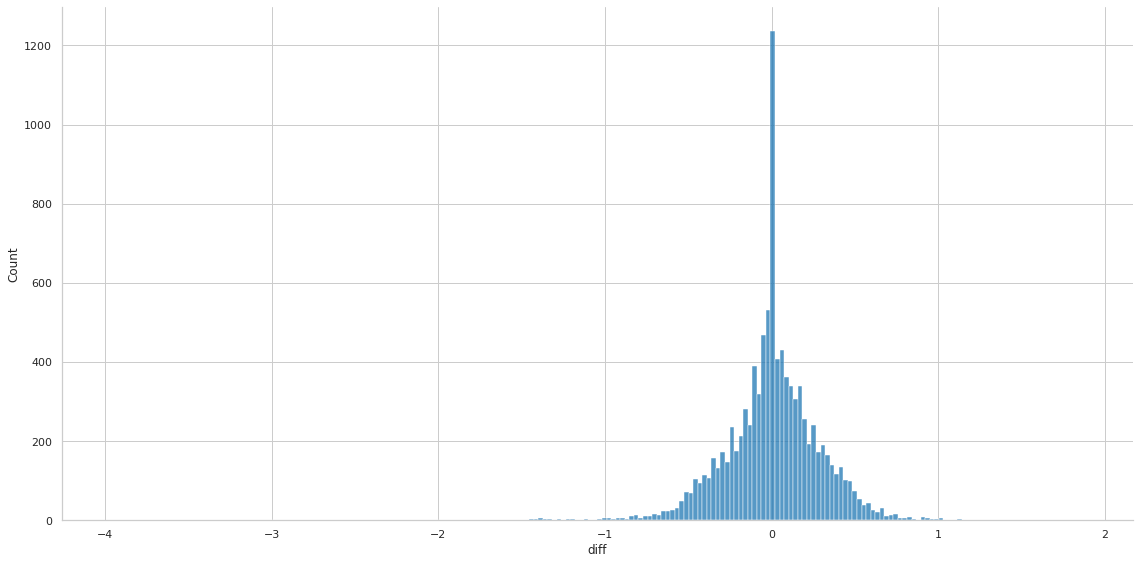

In [108]:
sns.displot(result['diff'], height = 8, aspect = 2)

Интересно получается. Настоящие рейтинги у нас округлены до 0.5, а предикты с точностью до 3 знаков после запятой, что гарантирует нам дополнительную ошибку. Округлим предикты и прогоним по новой.

In [109]:
X = data.query('sample==1').drop(['sample', 'rating']+todrop, axis=1)
y = data.query('sample==1')['rating']

  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)  

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
  
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
  
# Вот ниже округляем

y_pred = np.round(regr.predict(X_test)*2)/2

In [110]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.17268815052041633


Стало лучше!

In [111]:
result = pd.DataFrame(data = y_test)
result.columns = ['test']
result['pred'] = y_pred
result['diff'] = result['pred'] - result['test']
result

,test,pred,diff
ID_TA,,,
d9846411,4.0,4.0,0.0
d10353046,4.5,4.5,0.0
d4508301,3.0,3.0,0.0
d800704,3.5,4.0,0.5
d5012256,3.5,4.0,0.5
...,...,...,...
d10366272,5.0,4.5,-0.5
d718004,4.0,4.0,0.0
d6708839,3.0,3.0,0.0


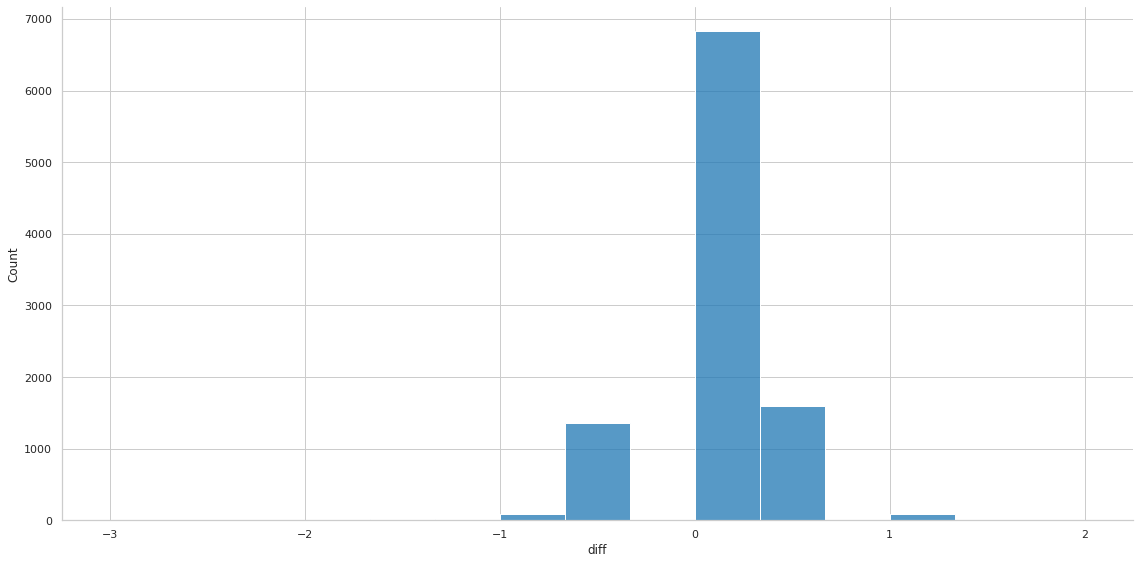

In [112]:
sns.displot(result['diff'], height = 8, aspect = 2)

Погнали работать с тестировочным датасетом. Для начала соберём подготовку данных.

<AxesSubplot:>

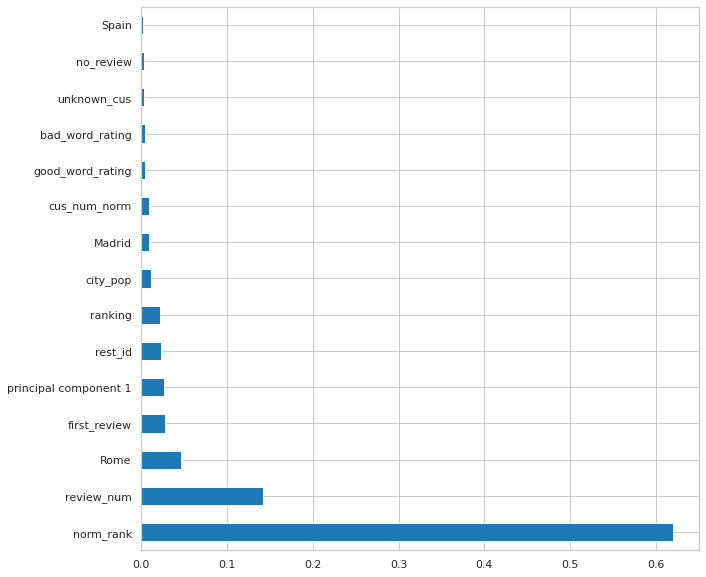

In [113]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

<AxesSubplot:>

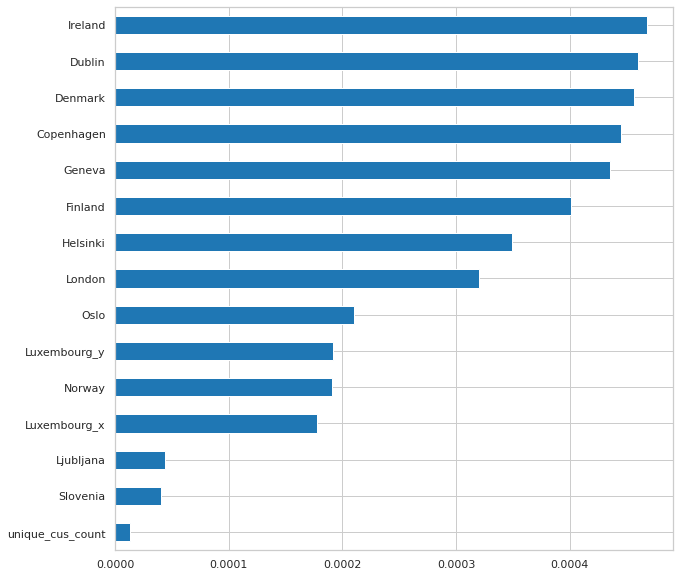

In [114]:
feat_importances.nsmallest(15).plot(kind='barh')

# 6. Функция для подготовки данных.

Начнём с самого начала, чтобы ноутбук можно было запустить с этой ячейки.

In [115]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import re
import collections
from pprint import *
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import os
import seaborn as sns
%matplotlib inline
#Make sure that input files are in place
for dirname, _, filenames in os.walk('./inputs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./inputs/global-city-population-estimates.xls
./inputs/kaggle_task.csv
./inputs/main_task.csv
./inputs/Без названия.ipynb
./inputs/.ipynb_checkpoints/main_task-checkpoint.csv
./inputs/.ipynb_checkpoints/Без названия-checkpoint.ipynb


In [116]:
#настройки графиков
sns.set(rc={'figure.figsize':(20,7)}, style = 'whitegrid', palette = 'tab10')
#зафиксируем random seed
RANDOM_SEED = 42

In [117]:
# на всякий случай, заново подгружаем данные
DATA_DIR = './inputs'
OUTPUT_DIR = './outputs'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Теперь напишем функцию для полной обработки данных.

In [118]:
def preproc_data(df_input):
    def eval_with_nans(review):
        '''
        Функция обрабатывает строки в столбце Reviews, преобразуя их в список вида [[Отзыв1, Отзыв2], [Дата1, Дата2]]
        Если в стоке есть nan в качестве отзыва или даты, то eval его не поймёт, выкинет исключение. В этом случае мы
        элемент nan заменим на строку "nan" и повторим попытку
        '''
        try:
            result = eval(review)
            return result
        except NameError:
            review = review.replace('nan', '"nan"')
            return eval_with_nans(review)
        
        
    def calculate_dt_nans(record):
        '''
        считаем разницу по времени, если одной из дат нет, то возвращаем None
        '''
        if (record['first_review'] == 0) or (record['last_review'] == 0):
            return None
        else:
            return (record['last_review'] - record['first_review'])/(10**16)
    
    
    def search_words(rating_list, frame):
        '''
        Функция проходит по датафрейму и формирует список из 100 слов, которые встречаются в отзывах на рестораны с рейтингом из rating list. Возвращает список слов-строк.
        '''
        words = frame[frame['rating'].isin(rating_list)]['reviews'].apply(lambda x: x[0] if (len(x) > 0) else [])
        words = words.apply(lambda x: str(x[0]).lower() + ' ' + str(x[1]).lower() if len(x)>1 else '')
        words_str = ''
        for phrase in words:
            if len(phrase) > 0:
                words_str+=phrase+' '
        words_str = re.sub('[\u263a-\U0001f645!\#\%\&\@\*\"\'\?\`]','', words_str) 
        words_ls = re.split('[\s+(\.\.\.)/]', words_str)
        words_ls = list(filter(lambda x: len(x)>3, words_ls))
        counter = collections.Counter(words_ls)
        result = []
        for word in counter.most_common(100):
            result.append(word[0])
        return result
    
    
    def search_words(rating_list, frame):
        '''
        Функция проходит по датафрейму и формирует список из 100 слов, которые встречаются в отзывах на рестораны с рейтингом из rating list. Возвращает список слов-строк.
        '''
        words = frame[frame['rating'].isin(rating_list)]['reviews'].apply(lambda x: x[0] if (len(x) > 0) else [])
        words = words.apply(lambda x: str(x[0]).lower() + ' ' + str(x[1]).lower() if len(x)>1 else '')
        words_str = ''
        for phrase in words:
            if len(phrase) > 0:
                words_str+=phrase+' '
        words_str = re.sub('[\u263a-\U0001f645!\#\%\&\@\*\"\'\?\`]','', words_str) 
        words_ls = re.split('[\s+(\.\.\.)/]', words_str)
        words_ls = list(filter(lambda x: len(x)>3, words_ls))
        counter = collections.Counter(words_ls)
        result = []
        for word in counter.most_common(100):
            result.append(word[0])
        return result
    
    
    def rate_review(record, words):
        '''
        Функция получает строку из фрейма record, считает сколько в отзывах есть слов из words и возвращает это число.
        '''
        reviews = str(record['reviews'][0]).lower()
        counter = 0
        for word in words:
            counter += len(re.findall(word, reviews))
        return counter
    
    # убираем ненужные для модели признаки
    df_output = df_input.copy()
    df_output.rename(columns = {'Restaurant_id':'rest_id', 
                             'City':'city', 
                             'Cuisine Style':'cus_style',
                             'Ranking':'ranking', 
                             'Rating':'rating', 
                             'Price Range': 'pricing',
                             'Reviews':'reviews',
                             'Number of Reviews':'review_num'},
                              inplace = True)


    # ################### 3. NAN ############################################################## 
    ##############
    # Кухни, пустые строчкеи меняем на Unknown, переводим в списки
    df_output['cus_style'].fillna(value = '["Unknown"]', inplace = True)
    df_output['cus_style'] = df_output['cus_style'].apply(lambda x: eval(x) 
                                                          if x!='nan' else ["Unknown"])
    # Отметка о том, что не указан тип кухни
    df_output['unknown_cus'] = df_output['cus_style'].apply(lambda x: 1 
                                                            if x == ["Unknown"] else 0)
    # Поменяем в ранкингах тип переменной
    df_output['ranking'] = df_output['ranking'].astype(np.uint16)
    # Отзывы
    df_output.reviews.fillna('[[], []]', inplace = True)
    df_output['reviews'] = df_output['reviews'].apply(eval_with_nans)
    # Количество отзывов, проверим сначала подозрительные
    df_output['no_review'] = (df_output['review_num'].apply(pd.isna)
                              .astype(np.uint8))
    df_output['review_num'].fillna(0, inplace = True)
    df_output['review_num'] = df_output['review_num'].astype(np.uint16)
    df_output.loc[df_output['pricing'].isnull(), 'pricing'] = \
        df_output['pricing'].mode()[0]
    
    # ################### 4. Encoding ############################################################## 
    # Города
    df_output = pd.merge(df_output, pd.get_dummies(df_output['city']), 
                         left_index=True, right_index=True)    
    # Ценовой диапазон
    df_output = pd.merge(df_output, pd.get_dummies(df_output['pricing']),
                         left_index=True, right_index=True)
    
    # ################### 5. Feature Engineering ####################################################
    # количество кухонь в ресторане
    df_output['cus_num'] = df_output['cus_style'].apply(len)
    # Пропишем 10 в рестораны, где кухонь больше 10
    df_output.loc[df_output['cus_num'] > 10, 'cus_num'] = 10
    # нормализация признака не помогает
    # популярные и уникальные кухни
    cus = df_output.explode(column = 'cus_style').reset_index()
    unique = (cus.groupby('cus_style').count()
              .sort_values(by = 'ID_TA', ascending = True))[0:11]
    top10 = (cus.groupby('cus_style').count().sort_values(by = 'ID_TA', ascending = False)
             .query('index!="Unknown"'))[0:11]
    df_output['pop_cus_count'] = df_output['cus_style'].apply(
                                 lambda x: len((set(x)).intersection(top10.index)))
    df_output['unique_cus_count'] = df_output['cus_style'].apply(
                                 lambda x: len((set(x)).intersection(unique.index)))
    #########################
    # Даты отзывов
    df_output['last_review'] = \
        df_output['reviews'].apply(lambda x: max(list(map(pd.to_datetime, x[1]))) 
                                   if x[1]!=[] 
                                   else pd.to_datetime(0)).astype(np.int64)
    df_output['first_review'] = \
        df_output['reviews'].apply(lambda x: min(list(map(pd.to_datetime, x[1]))) 
                                   if x[1]!=[] 
                                   else pd.to_datetime(0)).astype(np.int64)

    # Разница по времени между отзывами
    df_output['review_days_delta'] = df_output.apply(calculate_dt_nans, axis = 1)
    df_output['review_days_delta'].fillna(0, inplace = True)
    #нормализуем даты
    scaler = MinMaxScaler()
    res = np.array(scaler.fit_transform(np.array(df_output['first_review']).reshape(-1, 1)))
    df_output['first_review'] = pd.Series(res.flatten(), df_output.index)
    
    scaler = MinMaxScaler()
    res = np.array(scaler.fit_transform(np.array(df_output['last_review']).reshape(-1, 1)))
    df_output['last_review'] = pd.Series(res.flatten(), df_output.index)
    
    scaler = MinMaxScaler()
    res = np.array(scaler.fit_transform(np.array(df_output['review_days_delta']).reshape(-1, 1)))
    df_output['review_days_delta'] = pd.Series(res.flatten(), df_output.index)
    # Отметки об отсутствии данных
    df_output['no_first_review'] = df_output['first_review'].apply(lambda x: 0 if x!=0 else 1)
    df_output['no_second_review'] = df_output['last_review'].apply(lambda x: 0 if x!=0 else 1)
    df_output['no_time_delta'] = df_output['review_days_delta'].apply(lambda x: 1 if pd.isna(x) else 0)
    # Анализ слов в отзывах
    good = set(search_words([4.5,5], df_output))
    bad = set(search_words([0,0.5,1,1.5,2,2.5], df_output))
    good_new = good - bad 
    bad_new = bad - good 
    df_output['good_word_rating'] = df_output.apply(rate_review, axis = 1, words = good_new)
    df_output['bad_word_rating'] = df_output.apply(rate_review, axis = 1, words = bad_new)
    # стандартизация ранкингов по городам
    df_output['norm_rank'] = -1000
    for one_city in df_output['city'].unique():
        temp_df = df_output.loc[df_output['city'] == one_city].copy()
        scaler = StandardScaler()
        res = np.array(scaler.fit_transform(np.array(temp_df['ranking']).reshape(-1, 1)))
        df_output.loc[df_output['city'] == one_city, 'norm_rank'] = \
            pd.Series(res.flatten(), temp_df.index)
    ###################### External Data ##############################
    cities = df_output.city.unique()
    city_stats = pd.read_excel(DATA_DIR+'/global-city-population-estimates.xls', 
                               sheet_name='CITIES-OVER-300K', 
                               usecols=['Urban Agglomeration', 'Country or area', '2020'])

    city_stats.columns = ['country', 'city', 'pop']
    city_data = pd.DataFrame(columns = ['country', 'city', 'pop'])
    for city in cities:
        city_data = city_data.append(city_stats[city_stats['city'].str.contains(city)])
    city_data.city = cities
    city_data.set_index('city', inplace = True)

    df_output['city_pop'] = df_output['city'].apply(lambda x: city_data.loc[x, 'pop'])
    df_output['country'] = df_output['city'].apply(lambda x: city_data.loc[x, 'country'])

    df_output = pd.merge(df_output, pd.get_dummies(df_output['country']), 
                         left_index=True, right_index=True)
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    object_columns.remove('rest_id')
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

#### Запускаем и проверяем что получилось

In [119]:
df_preproc = preproc_data(data)

# 6. Модель.

In [120]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample', 'rest_id'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample', 'rest_id', 'rating'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
y_pred_rounded = np.round(y_pred*2)/2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [121]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAE с округлением результата:', metrics.mean_absolute_error(y_test, y_pred_rounded))

MAE: 0.20196749999999997
MAE с округлением результата: 0.16975


<AxesSubplot:>

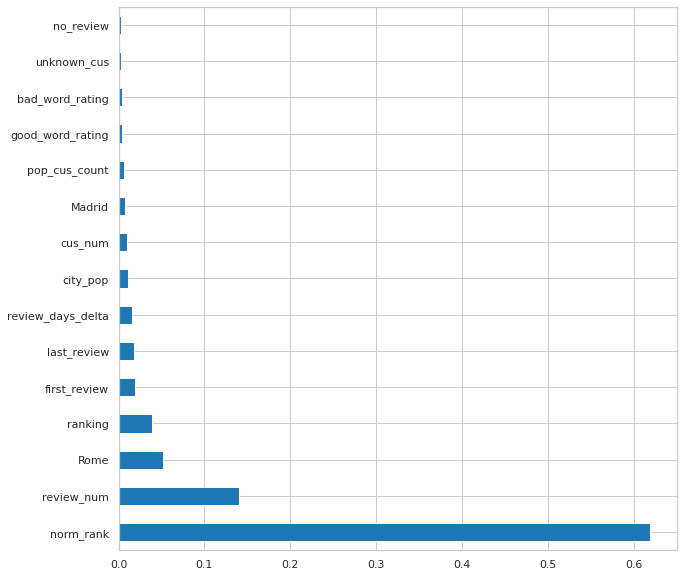

In [122]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

<AxesSubplot:>

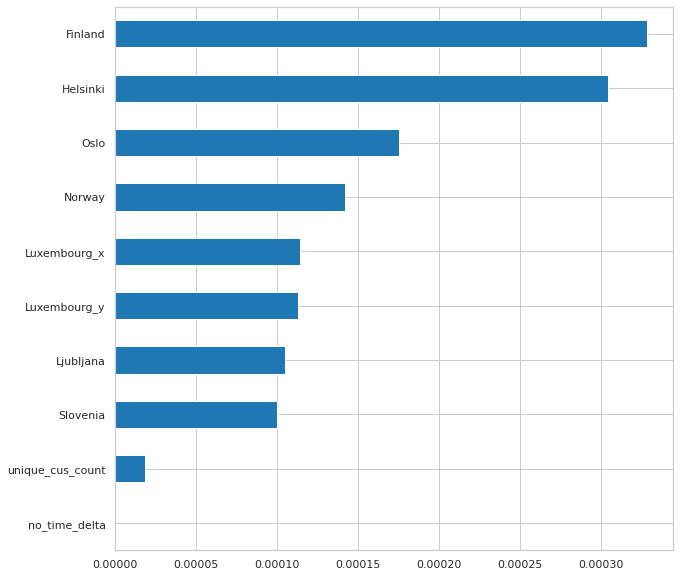

In [123]:
feat_importances.nsmallest(10).plot(kind='barh')

# 7. Сабмит.

In [124]:
predict_submission = np.round(model.predict(test_data)*2)/2

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [125]:
test_data['Rating'] = predict_submission
test_data['Restaurant_id'] = df_preproc.query('sample == 0')['rest_id']

In [126]:
test_data[['Restaurant_id','Rating']]

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.5


In [127]:
sample_submission = test_data[['Restaurant_id','Rating']].reset_index(drop=True)

In [128]:
sample_submission

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.5


In [130]:
sample_submission.to_csv(OUTPUT_DIR+'/submission.csv', index=False)